**16장 – RNN과 어텐션을 사용한 자연어 처리**

**자연어 처리의 목표와 연구 방향**

- 튜링 테스트를 통해 언어 능력을 평가하려는 시도가 있었지만, 실제 연구는 **텍스트 분류**, **번역**, **요약**, **질문-답변** 같은 구체적인 작업에 초점을 맞추고 있습니다.

**RNN의 활용과 발전**

- RNN은 자연어 처리 문제에서 중요한 역할을 하며, **상태가 없는 RNN**에서 시작해 **상태가 있는 RNN**을 통해 텍스트의 연속성을 학습합니다.
- RNN 기반으로 **감정 분석**, **기계 번역** 등을 수행할 수 있으며, **인코더-디코더 구조**를 통해 복잡한 자연어 처리 작업을 가능하게 합니다.

**어텐션 메커니즘과 트랜스포머의 중요성**

- **어텐션 메커니즘**은 모델이 특정 부분에 집중하도록 하여 성능을 향상시키는 기술입니다.
- **트랜스포머**는 RNN을 대체하는 모델로, 어텐션만 사용해 뛰어난 성능을 발휘하며, **GPT**와 **BERT** 같은 최신 언어 모델의 기반이 됩니다.

이 장에서는 자연어 처리의 다양한 기법을 소개하며, 실습을 통해 모델의 구조와 성능을 학습하는 방법을 설명합니다.

# 설정

이 프로젝트에는 Python 3.7 이상이 필요합니다:

In [1]:
import os
import sys

assert sys.version_info >= (3, 7)

그리고 TensorFlow ≥ 2.8:

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

2024-10-23 07:19:19.923865: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 07:19:19.923898: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 07:19:19.924612: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 07:19:19.988638: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 07:19:20.777842: W tensorflow/compiler/

이전 챕터에서 했던 것처럼 기본 글꼴 크기를 정의하여 그림을 더 예쁘게 만들어 보겠습니다:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## 한글 관련 처리
def get_font_family():
    import platform
    system_name = platform.system()
    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    elif system_name == "Linux":
        font_family = "NanumGothic"
    return font_family

font_family = get_font_family()
plt.rc("font", family=font_family)
plt.rc('axes', unicode_minus=False)
%config InlineBackend.figure_format='retina'

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# # 나눔 폰트를 사용합니다.
# import matplotlib 

# matplotlib.rc('font', family='NanumBarunGothic')
# matplotlib.rcParams['axes.unicode_minus'] = False

그리고 `images/nlp` 폴더를 만들고(아직 존재하지 않는 경우), 이 노트북을 통해 책에 사용할 그림을 고해상도로 저장하는 데 사용되는 `save_fig()` 함수를 정의해 보겠습니다:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "nlp"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    # plt.savefig(path, format=fig_extension, dpi=resolution)

이 챕터는 GPU가 없으면 매우 느려질 수 있으므로 GPU가 있는지 확인하거나 그렇지 않으면 경고를 표시합니다:

In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("GPU가 감지되지 않았습니다. 신경망은 GPU가 없으면 매우 느릴 수 있습니다.")
    if "google.colab" in sys.modules:
        print("런타임 > 런타임 유형 변경으로 이동하여 하드웨어 가속기에서 GPU를 선택합니다.")

2024-10-23 07:19:22.002340: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 07:19:22.068554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 07:19:22.068741: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# char-RNN을 사용하여 셰익스피어 같은 텍스트 생성하기

## 훈련 데이터셋 생성하기

안드레이 카파시의 [char-rnn 프로젝트](https://github.com/karpathy/char-rnn/)에서 셰익스피어 데이터를 다운로드해 보겠습니다.

In [6]:
import tensorflow as tf

shakespeare_url = "https://homl.info/shakespeare"  # 단축 URL
filepath = tf.keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [7]:
# 추가 코드 - 짧은 텍스트 샘플을 표시합니다.
print(shakespeare_text[:80])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


In [8]:
# 추가 코드 - 39개의 고유 문자를 모두 표시합니다(소문자로 변환 후).
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

- `tf.keras.layers.TextVectorization` 층을 사용하여 텍스트 데이터를 인코딩합니다. 여기서는 단어 수준 대신 문자(character) 수준으로 인코딩을 수행하며, 텍스트를 모두 소문자로 변환(`standardize="lower"`)하여 일관성을 유지합니다.

In [9]:
# TextVectorization 레이어를 생성합니다.
# 'split="character"'는 텍스트를 문자 단위로 분할합니다.
# 'standardize="lower"'는 모든 텍스트를 소문자로 변환합니다.
text_vec_layer = tf.keras.layers.TextVectorization(split="character",
                                                   standardize="lower")

# 셰익스피어 텍스트를 사용하여 레이어를 적응시킵니다.
# 이 과정에서 고유한 문자들의 어휘 사전이 생성됩니다.
text_vec_layer.adapt([shakespeare_text])

# 전체 셰익스피어 텍스트를 인코딩합니다.
# 각 문자는 해당하는 정수 ID로 변환됩니다.
# text_vec_layer([shakespeare_text])는 입력 텍스트를 벡터화한 결과를 포함하는 텐서를 반환합니다. 
# 이 텐서는 2차원 배열로, 첫 번째 차원은 배치 크기(여기서는 1)이고, 두 번째 차원은 벡터화된 텍스트의 길이입니다. 
encoded = text_vec_layer([shakespeare_text])[0] # [0] 은 배치를 제거 하기 위해

2024-10-23 07:19:23.837959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 07:19:23.838212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 07:19:23.838367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

- 인코딩 과정에서는 문자마다 고유한 정수 ID가 매핑되며, 패딩 토큰(0)과 알려지지 않은 문자(1)는 제외합니다. 

In [10]:
encoded -= 2  # 토큰 0(패딩)과 1(알 수 없음)을 드롭하는데, 이 토큰은 사용하지 않습니다.(음수가 되어 무시가 됨)
n_tokens = text_vec_layer.vocabulary_size() - 2  # 고유 문자 수 = 39
dataset_size = len(encoded)  # 총 문자 수 = 1,115,394

In [11]:
n_tokens

39

In [12]:
dataset_size

1115394

**시퀀스 데이터셋 생성**:
 - RNN 모델 훈련을 위해 텍스트를 시퀀스-투-시퀀스 형태로 변환합니다. 입력 시퀀스와 출력 시퀀스는 한 타임스텝만 차이가 나도록 설정합니다. 예를 들어, "to be or not to be"라는 텍스트가 있을 때, 다음 문자 예측을 목표로 한 시퀀스를 생성합니다
- 다음 함수는 시퀀스를 입력받아 지정된 길이의 윈도우를 만들고, 데이터셋을 입력 시퀀스와 타깃 시퀀스 쌍으로 변환합니다..

<img src="./images/fig_16_01.png" width=800>

In [13]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
    # 시퀀스를 텐서플로우 데이터셋으로 변환합니다.
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    
    # 윈도우 생성: 길이 length+1의 윈도우를 1씩 이동하며 생성합니다.
    # length 개의 요소는 입력 시퀀스가 되고, 마지막 요소는 타깃 시퀀스의 첫 번째 요소
    # drop_remainder=True는 마지막에 길이가 부족한 윈도우를 버립니다.
    ds = ds.window(length + 1, shift=1, drop_remainder=True)
    
    # 각 윈도우를 하나의 텐서로 변환합니다.
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
    
    # 데이터 셔플링 (옵션)
    if shuffle:
        ds = ds.shuffle(100_000, seed=seed)
    
    # 배치 생성
    ds = ds.batch(batch_size)
    
    # 입력과 타겟으로 분리: 
    # 입력은 윈도우의 처음부터 끝에서 두 번째 요소까지,
    # 타겟은 윈도우의 두 번째부터 마지막 요소까지입니다.
    # prefetch(1)은 다음 배치를 미리 준비하여 성능을 향상시킵니다.
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

In [14]:
# 추가 코드 - to_dataset()을 사용하는 간단한 예제
# 이 데이터셋에는 하나의 샘플만 있습니다. 입력은 "to b"이고 출력은 "o be"입니다.
list(to_dataset(text_vec_layer(["To be"])[0], length=4))

[(<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 4,  5,  2, 23]])>,
  <tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 5,  2, 23,  3]])>)]

**데이터셋 구성 및 분할**:
   - `to_dataset` 함수를 통해구성된  데이터셋을 훈련, 검증, 테스트 세트로 분할합니다
   -  전체 텍스트 데이터의 90%를 훈련, 5%를 검증, 5%를 테스트 세트로 사용합니다
   - 시퀀스 길이는 100으로 설정하였으며, 모델의 성능을 높이기 위해 이 값을 튜닝할 수 있습니다. 짧은 시퀀스는 학습 속도가 빠르지만, 긴 패턴을 학습하는 데는 불리할 수 있습니다..

In [15]:
# 시퀀스 길이 설정
length = 100

# 재현성을 위한 랜덤 시드 설정
tf.random.set_seed(42)

# 훈련 데이터셋 생성
# 전체 데이터의 처음 1,000,000개 토큰을 사용
# 셔플링을 적용하여 데이터의 순서를 무작위로 섞음
train_set = to_dataset(encoded[:1_000_000], length=length, shuffle=True, seed=42)

# 검증 데이터셋 생성
# 1,000,000번째부터 1,060,000번째 토큰까지 사용
valid_set = to_dataset(encoded[1_000_000:1_060_000], length=length)

# 테스트 데이터셋 생성
# 1,060,000번째 토큰부터 끝까지 사용
test_set = to_dataset(encoded[1_060_000:], length=length)

## Char-RNN 모델 구축 및 훈련하기

- 언어 모델링은 매우 큰 데이터셋을 필요로 하기 때문에 간단한 RNN 이상의 모델이 필요합니다. 이 예제에서는 **GRU(Gated Recurrent Unit)** 층을 사용해 RNN 모델을 구성합니다. GRU는 LSTM과 비슷한 성능을 내지만 더 간단한 구조로 연산이 빠릅니다.

**Embedding 층**: 텍스트 데이터에서 문자 ID를 입력받아 고차원 벡터로 변환합니다. 여기서 `input_dim`은 고유한 문자 ID의 개수(`n_tokens`), `output_dim`은 출력 벡터의 차원을 설정하며, 16으로 설정했습니다.

**GRU 층**: 128개의 유닛으로 구성된 GRU 층을 사용하며, `return_sequences=True`로 설정해 각 타임스텝의 출력을 다음 층으로 전달합니다. GRU는 시퀀스 데이터를 효율적으로 학습할 수 있는 순환 신경망의 한 종류입니다.

**Dense 층**: Dense 층은 각 문자에 대한 확률을 예측하며, 고유한 문자 개수(`n_tokens`)만큼의 출력을 생성합니다. `softmax` 활성화 함수를 사용해 출력 값들을 확률로 변환합니다.

**모델 컴파일 및 훈련**:  손실 함수는 `sparse_categorical_crossentropy`를 사용하고, 옵티마이저는 Nadam을 설정했습니다. `ModelCheckpoint` 콜백을 사용해 검증 정확도(`val_accuracy`)가 가장 높은 모델만 저장합니다.  . .

**참고**: (GPU가 있는 경우) `GRU` 클래스는 다음 매개변수의 기본값을 사용할 때 cuDNN 가속을 사용합니다: `activation`, `recurrent_activation`, `recurrent_dropout`, `unroll`, `use_bias`, `reset_after`.

In [16]:
import os

# 모델 파일 경로
model_path = "my_shakespeare_model"

# 재현성을 위해 랜덤 시드 설정
tf.random.set_seed(42)  # CPU에서 일관된 결과를 얻기 위함

# 모델 구조 정의
model = tf.keras.Sequential([
    # 입력 텍스트를 16차원 벡터로 변환하는 임베딩 층
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    
    # 128개의 유닛을 가진 GRU 층. return_sequences=True로 설정하여 모든 시퀀스 출력
    tf.keras.layers.GRU(128, return_sequences=True),
    
    # 출력 층: 각 토큰에 대한 확률 분포를 생성
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

# 모델 컴파일
model.compile(
    loss="sparse_categorical_crossentropy",  # 다중 분류 문제에 적합한 손실 함수
    optimizer="nadam",  # Nesterov Adam 옵티마이저 사용
    metrics=["accuracy"]  # 정확도를 평가 지표로 사용
)

# 모델 체크포인트 설정: 가장 좋은 모델만 저장
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    model_path,  # 저장할 모델 파일 이름
    monitor="val_accuracy",  # 검증 정확도를 기준으로 모델 저장
    save_best_only=True  # 가장 좋은 모델만 저장
)

In [17]:
# 모델이 이미 존재하는지 확인
if os.path.exists(model_path):
    print("모델을 불러옵니다.")
    model.load_weights(model_path)
else:
    print("모델을 학습합니다.")
    # 모델 훈련
    history = model.fit(
        train_set,
        validation_data=valid_set,
        epochs=10,
        callbacks=[model_ckpt]
    )

모델을 불러옵니다.


2024-10-23 07:19:28.208686: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open my_shakespeare_model: FAILED_PRECONDITION: my_shakespeare_model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


**예측을 위한 전처리**
- 이 모델은 기본적으로 텍스트 전처리를 포함하지 않으므로, 최종 모델에서는 `tf.keras.layers.TextVectorization` 층과 함께 사용해야 합니다.
- `<PAD>`와 `<UNK>` 토큰을 제외하기 위해 `Lambda` 층을 추가하여 문자 ID에서 2를 빼줍니다.

In [18]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # <PAD>나 <UNK> 토큰 없음
    model
])

- 이 모델을 사용해 주어진 시퀀스의 다음 문자를 예측할 수 있습니다.

In [19]:
y_proba = shakespeare_model.predict(["To be or not to b"])[0, -1]
y_pred = tf.argmax(y_proba)  # 가장 가능성이 높은 문자 ID 선택
text_vec_layer.get_vocabulary()[y_pred + 2]

1/1 [==============================] - 0s 260ms/step


2024-10-23 07:19:29.134786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


'e'

## 가짜 셰익스피어 텍스트 생성하기유도합니다.



**Char-RNN 모델을 사용하여 텍스트 생성**
- Char-RNN 모델을 이용해 새 텍스트를 생성할 때, 초기 텍스트를 주입하고 모델이 가장 가능성 있는 다음 글자를 예측합니다. 예측된 글자를 텍스트 끝에 추가하고 이를 다시 입력하여 다음 글자를 예측하는 과정을 반복합니다. 이를 **그리디 디코딩(greedy decoding)** 이라고 합니다.

**무작위 선택**
- 반복적인 단어 선택을 피하기 위해, `tf.random.categorical` 함수를 사용하여 모델의 예측 확률에 기반해 무작위로 다음 글자를 선택할 수 있습니다. 이 방법은 텍스트의 다양성을 높여줍니다.

**온도(temperature) 조절**
- 모델이 예측한 확률(로그 확률)을 `temperature`로 나누어 무작위 선택의 다양성을 조절합니다. 낮은 온도는 더 결정적인 선택을, 높은 온도는 더 다양한 선택을 유도합니다.

In [20]:
# 로그 확률 설정
# [[0.5, 0.4, 0.1]]는 각각 0, 1, 2에 대한 확률을 나타냅니다.
log_probas = tf.math.log([[0.5, 0.4, 0.1]])  # 확률 = 50%, 40%, 10%

# 재현성을 위해 랜덤 시드 설정
tf.random.set_seed(42)

# 카테고리별 확률에 따라 8개의 샘플 추출
# categorical 함수는 주어진 로그 확률에 따라 카테고리를 무작위로 선택합니다.
# num_samples=8은 8개의 샘플을 추출한다는 의미입니다.
samples = tf.random.categorical(log_probas, num_samples=8)

# 결과 출력
print("추출된 샘플:", samples.numpy())

추출된 샘플: [[0 0 1 1 1 0 0 0]]


- `next_char` 함수는 주어진 텍스트를 바탕으로 다음 문자를 예측하고 반환합니다.

In [21]:
def next_char(text, temperature=1):
    # 주어진 텍스트에 대해 모델의 예측 확률을 계산합니다.
    # [0, -1:]는 마지막 문자의 예측 확률만 선택합니다.
    y_proba = shakespeare_model.predict([text])[0, -1:]
    
    # 예측 확률을 로그 스케일로 변환하고 온도로 나눕니다.
    # 온도가 낮을수록 더 결정적인 선택을, 높을수록 더 다양한 선택을 유도합니다.
    rescaled_logits = tf.math.log(y_proba) / temperature
    
    # 조정된 로그 확률을 기반으로 다음 문자의 ID를 무작위로 선택합니다.
    char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
    
    # 선택된 문자 ID를 실제 문자로 변환하여 반환합니다.
    # +2는 패딩과 시작 토큰을 고려한 오프셋입니다.
    return text_vec_layer.get_vocabulary()[char_id + 2]

- `extend_text` 함수는 `next_char`를 반복 호출하여 입력 텍스트를 확장합니다.

In [22]:
def extend_text(text, n_chars=50, temperature=1):
    # 주어진 텍스트를 지정된 문자 수만큼 확장하는 함수입니다.
    # text: 확장할 초기 텍스트
    # n_chars: 추가할 문자 수 (기본값: 50)
    # temperature: 다음 문자 선택의 무작위성을 조절하는 매개변수 (기본값: 1)
    
    for _ in range(n_chars):
        # n_chars만큼 반복하여 텍스트를 확장합니다.
        # next_char 함수를 사용하여 다음 문자를 예측하고 텍스트에 추가합니다.
        text += next_char(text, temperature)
    
    # 확장된 텍스트를 반환합니다.
    return text

In [23]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

- **온도에 따른 결과 비교**:
  - `temperature=0.01`: 모델이 매우 결정적인 선택을 하며, 기존 텍스트와 유사한 패턴을 따릅니다.
  - `temperature=1`: 약간의 다양성이 있으며, 텍스트가 자연스럽게 이어집니다.
  - `temperature=100`: 너무 많은 다양성을 주어 무작위성이 커져서 텍스트가 의미를 잃게 됩니다.

In [24]:
print(extend_text("To be or not to be", temperature=0.01))

1/1 [==============================] - 0s 18ms/step
To be or not to be made the duke
of the duke and the death, and the 


In [25]:
print(extend_text("To be or not to be", temperature=1))

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
To be or not to beggar but
for your counter's crown and beside
as gl


In [26]:
print(extend_text("To be or not to be", temperature=100))

1/1 [==============================] - 0s 17ms/step
To be or not to bepevicm-vilv!?$ez?gmjz :3?ljb'va;!td&hi.ur3l'-j!3eu


## 상태가 있는 RNN

**상태가 없는 RNN(stateless RNN)**:
- 각 배치마다 모델의 은닉 상태를 0으로 초기화합니다. 이로 인해, 이전 배치와의 연결이 끊어지고, 장기적인 의존 관계를 학습하기 어렵습니다.

**상태가 있는 RNN(stateful RNN)**: 
- 각 배치의 마지막 상태를 다음 배치의 초기 상태로 전달합니다. 이 방법을 사용하면 모델이 장기간 패턴을 학습할 수 있습니다.

**데이터셋 준비** : 상태가 있는 RNN은 입력 시퀀스가 순차적이어야 하며, 배치가 순서대로 처리되도록 준비해야 합니다. 따라서 데이터셋을 생성할 때 다음과 같은 작업이 필요합니다:

1. **윈도우 생성**: 시퀀스를 `length + 1` 크기의 윈도우로 나누고, `shift=n_steps`로 설정하여 윈도우 사이의 겹침을 피합니다. 이렇게 하면 배치 사이의 연속성을 유지할 수 있습니다.
2. **배치 크기 설정**: 상태가 있는 RNN에서는 배치의 첫 번째 차원 크기를 1로 설정합니다. 이는 각 배치의 첫 번째 시퀀스의 시작이 이전 배치의 마지막 시퀀스의 끝과 이어지도록 보장합다.
니다.

<img src="./images/fig_16_02.png" width=800>

**예시**
- **윈도우 생성**:
  - 시퀀스: `A B C D E F G H`
  - `length = 3`, `shift = 3`일 때,
  - 윈도우: `[A B C D]`, `[D E F G]`, `[G H]` (마지막은 드롭될 수 있음)

- **배치 크기 설정**:
  - 각 윈도우는 하나의 배치로 처리됩니다.
  - 첫 번째 배치는 `[A B C D]`로 시작하고, 두 번째 배치는 `[D E F G]`로 이어지며 상태가 유지됩니다.

- 다음 코드는 시퀀스 데이터를 연속적인 윈도우로 나누어, 상태가 있는 RNN 훈련에 맞는 데이터셋을 만듭니다.

In [27]:
def to_dataset_for_stateful_rnn(sequence, length):
    # 시퀀스를 텐서 슬라이스로 변환
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    
    # 윈도우 생성: length + 1 크기의 윈도우를 만들고, length만큼 이동
    # drop_remainder=True로 설정하여 마지막 불완전한 윈도우를 제거
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    
    # 각 윈도우를 하나의 텐서로 변환하고 배치 크기를 1로 설정
    ds = ds.flat_map(lambda window: window.batch(length + 1)).batch(1)
    
    # 입력(X)과 타겟(y) 분리: X는 처음 length개 요소, y는 마지막 length개 요소
    # prefetch(1)을 사용하여 데이터 로딩 최적화
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)


# 상태가 있는 RNN용 훈련, 검증, 테스트 세트 준비
# 전체 데이터를 훈련, 검증, 테스트 세트로 분할
stateful_train_set = to_dataset_for_stateful_rnn(encoded[:1_000_000], length)  # 처음 1,000,000개 문자로 훈련 세트 생성
stateful_valid_set = to_dataset_for_stateful_rnn(encoded[1_000_000:1_060_000], length)  # 다음 60,000개 문자로 검증 세트 생성
stateful_test_set = to_dataset_for_stateful_rnn(encoded[1_060_000:], length)  # 나머지 문자로 테스트 세트 생성

In [28]:
# 추가 코드 - to_dataset_for_stateful_rnn()을 사용한 간단한 예제
list(to_dataset_for_stateful_rnn(tf.range(10), 3))

[(<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[0, 1, 2]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[1, 2, 3]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[3, 4, 5]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[4, 5, 6]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[6, 7, 8]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[7, 8, 9]], dtype=int32)>)]

배치당 두 개 이상의 윈도가 있다면 `to_dataset_for_stateful_rnn()` 대신 `to_batched_dataset_for_stateful_rnn()` 함수를 사용할 수 있습니다:

In [29]:
# 상태가 있는 RNN을 위해 배치 데이터셋을 준비하는 방법을 보여주는 코드입니다.

import numpy as np

def to_non_overlapping_windows(sequence, length):
    # 시퀀스를 겹치지 않는 윈도우로 나누는 함수
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    # length + 1 크기의 윈도우를 만들고, length만큼 이동
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    # 각 윈도우를 하나의 텐서로 변환
    return ds.flat_map(lambda window: window.batch(length + 1))

def to_batched_dataset_for_stateful_rnn(sequence, length, batch_size=32):
    # 시퀀스를 배치 크기만큼 나눕니다.
    parts = np.array_split(sequence, batch_size)
    # 각 부분에 대해 겹치지 않는 윈도우를 생성합니다.
    datasets = tuple(to_non_overlapping_windows(part, length) for part in parts)
    # 모든 부분 데이터셋을 하나로 결합합니다.
    ds = tf.data.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows))
    # 입력(X)과 타겟(y)을 분리하고 데이터 로딩을 최적화합니다.
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

# 예제: 0부터 19까지의 숫자를 사용하여 배치 데이터셋을 생성합니다.
list(to_batched_dataset_for_stateful_rnn(tf.range(20), length=3, batch_size=2))

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 0,  1,  2],
         [10, 11, 12]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 1,  2,  3],
         [11, 12, 13]], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 3,  4,  5],
         [13, 14, 15]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 4,  5,  6],
         [14, 15, 16]], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 6,  7,  8],
         [16, 17, 18]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 7,  8,  9],
         [17, 18, 19]], dtype=int32)>)]

**상태가 있는 RNN 모델 구성**

1. **Embedding 층**: 문자 ID를 임베딩 벡터로 변환합니
    - `batch_input_shape=[1, None]`는 배치 크기를 1로 설정하여 상태를 유지하는데 필요한 설정입니다.다3
2. **GRU 층**: `stateful=True`를 설정하여 은닉 상태를 다음 배치로 유지합니4.
3. **Dense 층**: 각 문자에 대한 확률을 예측합니다.

In [30]:
# 랜덤 시드 설정으로 실험 결과의 재현성 보장
tf.random.set_seed(42)

# 상태가 있는 RNN 모델 구성
model = tf.keras.Sequential([
    # Embedding 층: 문자 ID를 16차원 벡터로 변환
    # batch_input_shape=[1, None]은 배치 크기를 1로 고정하여 상태 유지
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16,
                              batch_input_shape=[1, None]),
    
    # GRU 층: 128개의 유닛을 가진 순환 신경망 층
    # return_sequences=True로 설정하여 모든 타임스텝의 출력을 반환
    # stateful=True로 설정하여 배치 간 상태를 유지
    tf.keras.layers.GRU(128, return_sequences=True, stateful=True),
    
    # Dense 층: 각 문자에 대한 확률을 출력
    # activation="softmax"로 설정하여 확률 분포를 생성
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

**상태 초기화 콜백** : 
- 상태가 있는 RNN에서는 에포크가 끝날 때마다 은닉 상태를 초기화해야 합니다. 이를 위해 사용자 정의 콜백을 작성합니다.
- 이는, 데이터의 순서에 의존하지 않고 학습할 수 있게 하기 위해, 각 에포크가 독립적으로 시작되도록 보장하기 위함입니다.

In [31]:
# ResetStatesCallback 클래스 정의
class ResetStatesCallback(tf.keras.callbacks.Callback):
    # 각 에포크가 시작될 때 호출되는 메서드
    def on_epoch_begin(self, epoch, logs):
        # 모델의 상태를 초기화합니다.
        # 이는 상태가 있는 RNN에서 각 에포크 시작 시 이전 에포크의 상태를 리셋하는 데 중요합니다.
        self.model.reset_states()

In [32]:
# 모델 파일 경로
model_path = "my_stateful_shakespeare_model"

# 추가 코드 - 다른 디렉터리를 사용하여 체크포인트를 저장합니다.
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    model_path,
    monitor="val_accuracy",
    save_best_only=True)

**경고**: 다음 셀을 실행하는 데 시간이 걸릴 수 있습니다(GPU를 사용하지 않는 경우 1시간 정도 소요될 수 있음).

**모델 컴파일 및 훈련**
- `ResetStatesCallback` 콜백을 사용해 에포크가 시작될 때마다 모델의 상태를 초기화합니다.
- `stateful=True` 설정으로 인해, 모델은 이전 배치의 상태를 다음 배치로 유지합니다. 따라서 훈련 및 평가 시 **배치 크기와 시퀀스 길이를 일관되게 설정**해야 합니다


In [33]:
# 모델이 이미 존재하는지 확인
if os.path.exists(model_path):
    print("모델을 불러옵니다.")
    model.load_weights(model_path)
else:
    print("모델을 학습합니다.")
    model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
                  metrics=["accuracy"])
    history = model.fit(stateful_train_set, validation_data=stateful_valid_set,
                        epochs=10, callbacks=[ResetStatesCallback(), model_ckpt])

모델을 불러옵니다.


2024-10-23 07:19:37.984249: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open my_stateful_shakespeare_model: FAILED_PRECONDITION: my_stateful_shakespeare_model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [34]:
# shakespeare_model을 사용하여 예측 실행
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # <PAD>나 <UNK> 토큰 없음
    model
])

# 예측을 위한 입력 텍스트
input_text = "To be or not to b"

# 예측 실행
y_proba = shakespeare_model.predict([input_text])[0, -1]
y_pred = tf.argmax(y_proba)  # 가장 가능성이 높은 문자 ID 선택

# 예측된 문자 출력
predicted_char = text_vec_layer.get_vocabulary()[y_pred + 2]
print(f"입력 텍스트: '{input_text}'")
print(f"예측된 다음 문자: '{predicted_char}'")

1/1 [==============================] - 0s 180ms/step
입력 텍스트: 'To be or not to b'
예측된 다음 문자: 'e'


- **감정 뉴런 발견**: 2017년 연구에서 Char-RNN 기반 모델이 특정 뉴런을 통해 감정 분류에서 높은 성능을 보였으며, 이는 비지도 사전 훈련의 효과를 시사합니다.
- **Char-RNN의 한계**: 단순한 다음 문자 예측은 문맥 파악에 한계가 있어 감정 분석에 추가 학습이 필요합니다.
- **다음 단계**: 단어 수준의 모델과 마스킹을 활용해 감정 분석 방법을 학습할 예정입니다.

# 감성 분석

텍스트 생성은 유용하지만, 실제 NLP 프로젝트에서는 텍스트 분류와 같은 실용적인 작업이 더 흔합니다. 그중에서도 **감성 분석**은 영화 리뷰, 고객 피드백 분석 등에서 널리 사용되는 응용 분야입니다.


**IMDb 감성 분석 데이터셋**

- IMDb 데이터셋은 영어로 작성된 영화 리뷰 50,000개로 구성되어 있습니다. 이 중 25,000개는 훈련용, 나머지 25,000개는 테스트용으로 나누어져 있으며, 각 리뷰는 긍정적(1) 또는 부정적(0) 레이블이 붙어 있습니다.
- 이 데이터셋은 간단한 이진 분류 문제를 다루기에 적합하며, 노트북 환경에서 빠르게 처리할 수 있어 실습에 유리합니다.

**데이터 로드 및 전처리**

- `tensorflow_datasets` 라이브러리를 사용해 IMDb 데이터를 로드하고, 훈련, 검증, 테스트 세트로 나눕니다.
- 데이터의 90%를 훈련에 사용하고, 나머지 10%를 검증 세트로 활용합니다.

In [35]:
import tensorflow_datasets as tfds

# IMDb 데이터셋을 로드합니다.
# tfds.load() 함수를 사용하여 데이터를 가져옵니다.
raw_train_set, raw_valid_set, raw_test_set = tfds.load(
    name="imdb_reviews",  # IMDb 리뷰 데이터셋을 선택합니다.
    split=["train[:90%]", "train[90%:]", "test"],  # 데이터를 훈련, 검증, 테스트 세트로 나눕니다.
    as_supervised=True  # 데이터를 (입력, 레이블) 쌍으로 반환합니다.
)

# 랜덤 시드를 설정하여 결과의 재현성을 보장합니다.
tf.random.set_seed(42)

# 훈련 데이터셋을 준비합니다.
train_set = (
    raw_train_set
    .shuffle(5000, seed=42)  # 데이터를 섞습니다.
    .batch(32)  # 배치 크기를 32로 설정합니다.
    .prefetch(1)  # 성능 향상을 위해 데이터를 미리 가져옵니다.
)

# 검증 데이터셋을 준비합니다.
valid_set = raw_valid_set.batch(32).prefetch(1)

# 테스트 데이터셋을 준비합니다.
test_set = raw_test_set.batch(32).prefetch(1)

- 일부 리뷰는 "terrible movie"와 같이 부정적인 감정을 명확하게 나타내지만, 모든 리뷰가 분류하기 쉬운 것은 아닙니다. 예를 들어, 부정적 리뷰로 시작하다가 긍정적인 내용을 포함하는 경우도 있어, 모델이 정확한 감정 분석을 위해서는 문맥을 잘 파악해야 합니다.

In [36]:
# raw_train_set에서 4개의 샘플을 가져와 리뷰와 레이블을 출력합니다.
for review, label in raw_train_set.take(4):
    # 리뷰 텍스트를 UTF-8로 디코딩하고 처음 200자만 출력합니다.
    print(review.numpy().decode("utf-8")[:200], "...")
    
    # 해당 리뷰의 레이블(긍정 또는 부정)을 출력합니다.
    print("레이블:", label.numpy())
    
    # 각 샘플 사이에 빈 줄을 추가하여 가독성을 높입니다.
    print()

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
레이블: 0

I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
레이블: 0

Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Moun ...
레이블: 0

This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful perf ...
레이블: 1



2024-10-23 07:19:41.191445: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


각 리뷰는 영화에 대한 감정을 표현하고 있으며, 레이블은 그 감정이 긍정적인지(1) 부정적인지(0)를 나타냅니다. 

1. **첫 번째 리뷰**: 
   - 내용: "This was an absolutely terrible movie..."로 시작하며, 영화가 매우 나빴다고 평가하고 있습니다. Christopher Walken과 Michael Ironside 같은 훌륭한 배우들이 출연했지만, 그들의 최악의 역할이라고 언급합니다.
   - 레이블: 0 (부정적)

2. **두 번째 리뷰**:
   - 내용: "I have been known to fall asleep during films..."로 시작하며, 보통 피곤하거나 편안한 환경에서 영화를 보다가 잠들곤 하지만, 이 영화는 특별히 지루했다고 암시합니다.
   - 레이블: 0 (부정적)

3. **세 번째 리뷰**:
   - 내용: "Mann photographs the Alberta Rocky Mountains in a superb fashion..."로 시작하며, 영화의 촬영과 배우들의 연기를 칭찬하지만, 할리우드의 특정한 표현 방식에 대해 비판적인 의견을 제시합니다.
   - 번역 : Mann은 알버타 로키 산맥을 훌륭하게 촬영했고, Jimmy Stewart와 Walter Brennan은 항상 그렇듯이 즐거운 연기를 선보입니다. 하지만 할리우드, 제발...
   - 레이블: 0 (부정적)

4. **네 번째 리뷰**:
   - 내용: "This is the kind of film for a snowy Sunday afternoon..."로 시작하며, 편안한 오후에 즐기기 좋은 영화라고 평가하며, 훌륭한 연기를 칭찬합니다.
   - 레이블: 1 (긍정적)

이러한 리뷰와 레이블은 감정 분석 모델을 훈련시키는 데 사용될 수 있습니다. 모델은 텍스트를 분석하여 긍정적 또는 부정적 감정을 예측하게 됩니다.

**텍스트 벡터화와 문제점**

- 단어 단위의 텍스트 토큰화를 위해 `tf.keras.layers.TextVectorization` 층을 사용합니다. 이 층은 공백을 기준으로 단어를 구분하지만, 일부 언어에서는 공백 토큰화가 제대로 작동하지 않을 수 있습니다.
- 예를 들어, 중국어나 베트남어는 공백을 사용하지 않거나, 독일어에서는 여러 단어를 합성해 사용하는 경우가 많습니다. 영어에서도 "San Francisco"나 "#LoveDeepLearning"처럼 공백 없이 텍스트가 이어질 수 있습니다.

**부분 단어 인코딩 (Subword Tokenization)**

- 2016년 에든버러 대학교의 리코 젠리치(Rico Sennrich) 등이 제안한 **바이트 페어 인코딩(Byte Pair Encoding, BPE)** 기법은 텍스트를 부분 단어 수준으로 토큰화합니다.
- BPE는 희귀한 단어라도 그 의미를 유추할 수 있도록 하며, 가장 빈번한 문자 쌍을 반복적으로 결합해 단어를 생성합니다. 예를 들어, "smartest"라는 단어는 "smart"와 "est"로 나눠 학습할 수 있습니다.

**부분 단어 토큰화와 정규화**

- 2018년 구글의 타쿠 구도(Taku Kudo) 등의 연구에서는 **부분 단어 정규화(subword regularization)** 기법을 통해 기존의 토큰화 전략을 개선했습니다.
- 예를 들어, "New England"를 "New" + "England"로 분할하거나, "NewEngland"처럼 하나의 토큰으로 처리하는 유연한 방식이 가능합니다.
- **SentencePiece** 라이브러리는 이러한 부분 단어 정규화 및 토큰화 전략을 지원합니다.

**텍스트 벡터화 설정**

- 영어 텍스트에서는 공백을 기준으로 단어를 나누는 **TextVectorization** 층이 효과적입니다. 이 층을 사용해 IMDb 데이터셋의 텍스트를 벡터화합니다.
- 어휘 사전 크기(`vocab_size`)를 1,000개로 제한하고, 가장 빈번한 단어들을 사용하여 벡터화합
- 다음 코드는 훈련 세트를 기반으로 `TextVectorization` 층을 학습하여 텍스트 벡터화 모델을 준비합니다.니다.

In [37]:
# 어휘 사전 크기를 1000개로 설정합니다.
vocab_size = 1000

# TextVectorization 층을 생성합니다. 최대 토큰 수를 vocab_size로 제한합니다.
text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)

# 훈련 데이터셋에서 리뷰 텍스트만 추출하여 TextVectorization 층을 적응시킵니다.
# 이 과정에서 가장 빈번한 1000개의 단어로 어휘 사전이 구성됩니다.
text_vec_layer.adapt(train_set.map(lambda reviews, labels: reviews))

**모델 구성과 훈련**

- 벡터화된 텍스트를 임베딩 벡터로 변환한 후, GRU 층과 Dense 층을 사용해 감성 분석 모델을 구성합니
- **텍스트 벡터화 층**: 단어를 ID로 변환하여 모델의 첫 번째 층으로 사용합니다.
- **임베딩 층**: 단어 ID를 `embed_size` 크기의 벡터로 변환합니다.
- **GRU 층**: 시퀀스 데이터를 처리하며, 영화 리뷰의 감정을 예측하는 데 도움이 됩니다.
- **Dense 층**: 시그모이드 활성화 함수로 감정(긍정/부정)에 대한 확률을 출력합.

**경고**: 다음 셀은 실행하는 데 몇 분 정도 걸리며 패딩 토큰을 마스킹하지 않았기 때문에 모델이 아무것도 학습하지 못할 수 있습니다(다음 섹션의 요점입니다).

In [38]:
# 모델 파일 경로
model_path = "my_imbd_model"

# 모델이 이미 존재하는지 확인
if os.path.exists(model_path):
    print("모델을 불러옵니다.")
    model = tf.keras.models.load_model(model_path)  # TensorFlow 형식으로 저장된 모델 불러오기
else:
    print("모델을 학습합니다.")
    # 임베딩 벡터의 크기를 128로 설정합니다.
    embed_size = 128

    # 재현성을 위해 랜덤 시드를 설정합니다.
    tf.random.set_seed(42)

    # 순차적 모델을 생성합니다.
    model = tf.keras.Sequential([
        # 텍스트 벡터화 층: 입력 텍스트를 정수 시퀀스로 변환합니다.
        text_vec_layer,
        
        # 임베딩 층: 각 단어를 128차원의 벡터로 변환합니다.
        tf.keras.layers.Embedding(vocab_size, embed_size),
        
        # GRU 층: 128개의 유닛을 가진 순환 신경망 층입니다.
        tf.keras.layers.GRU(128),
        
        # 출력 층: 시그모이드 활성화 함수를 사용하여 0과 1 사이의 확률을 출력합니다.
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    # 모델을 컴파일합니다.
    model.compile(
        loss="binary_crossentropy",  # 이진 분류를 위한 손실 함수
        optimizer="nadam",           # Nadam 옵티마이저 사용
        metrics=["accuracy"]         # 정확도를 평가 지표로 사용
    )

    # 추가 코드 - 다른 디렉터리를 사용하여 체크포인트를 저장합니다.
    model_ckpt = tf.keras.callbacks.ModelCheckpoint(
        model_path,
        monitor="val_accuracy",
        save_best_only=True,
        save_format='tf'  # TensorFlow 형식으로 저장
    )

    # 모델을 훈련합니다.
    history = model.fit(
        train_set,                   # 훈련 데이터셋
        validation_data=valid_set,   # 검증 데이터셋
        epochs=2,                    # 2번의 에포크 동안 훈련
        callbacks=[model_ckpt]       # 체크포인트 콜백 추가
    )

모델을 불러옵니다.


In [39]:
# 모델 평가
loss, accuracy = model.evaluate(test_set)
print(f"테스트 손실: {loss}")
print(f"테스트 정확도: {accuracy}")

782/782 [==============================] - 8s 10ms/step - loss: 0.6934 - accuracy: 0.5037
테스트 손실: 0.6934386491775513
테스트 정확도: 0.5036799907684326


**훈련 문제**: 모델을 훈련할 때 일반적으로 전혀 학습하지 못하고 정확도가 50% 정도로 무작위 추측과 비슷하게 나올 수 있습니다.

**이유**: `TextVectorization` 층이 다른 길이의 리뷰를 시퀀스로 변환하는 과정에서 패딩 토큰(0)을 사용하기 때문에 대부분의 시퀀스가 패딩으로 채워지며, 모델이 패딩에만 집중하게 됩니다.

**해결책**:
- 짧은 리뷰를 무시하고 고정된 길이의 배치를 사용하는 방법.
- 패딩 토큰을 무시하거나 마스킹을 적용하는 방법.

## 마스킹

**마스킹의 역할**: 모델이 패딩 토큰을 무시하도록 설정할 수 있으며, 이는 케라스에서 `Embedding` 층을 만들 때 `mask_zero=True`를 설정하여 간단하게 구현할 수 있습니다. 이 설정은 패딩 토큰(ID가 0)인 경우 이를 무시하도록 합니다.

**마스크 전달 메커니즘**:
   - `Embedding` 층에서 생성된 마스크는 모델의 다음 층으로 자동 전달됩니다. 이를 통해 모델은 패딩을 무시하고 유효한 데이터만 학습하게 됩니다.
   - 순환 신경망(RNN) 층이나 GRU 층과 같은 층은 마스킹된 타임 스텝을 무시하고, 필요한 경우 여러 층으로 전달될 수 있습니다.

**적용 시 주의 사항**:
   - LSTM과 GRU 층은 특정 조건 하에서만 마스킹을 완벽히 지원합니다. 예를 들어, 모든 패딩 토큰이 시퀀스의 끝에 있는 경우에만 GPU 가속이 적용될 수 있습니다.
   - 다른 하이퍼파라미터가 기본값으로 설정되지 않은 경우, GPU 최적화가 되지 않아 속도가 느려질 수 있습니다.

**마스킹 제한**: 모든 층이 마스킹을 지원하는 것은 아닙니다. 예를 들어, 합성곱 층은 일반적으로 마스킹을 지원하지 않습니다.

**경고**: 다음 셀을 실행하는 데 시간이 걸립니다(GPU를 사용하지 않는 경우 30분 정도 소요될 수 있습니다).

In [45]:
# 모델 파일 경로
model_path = "my_imbd_mask_model"

# 모델이 이미 존재하는지 확인
if os.path.exists(model_path):
    print("모델을 불러옵니다.")
    model = tf.keras.models.load_model(model_path)  # TensorFlow 형식으로 저장된 모델 불러오기
else:
    print("모델을 학습합니다.")
    # 임베딩 벡터의 크기를 128로 설정합니다.


    # 재현성을 위해 랜덤 시드를 설정합니다.
    tf.random.set_seed(42)

    # 순차적 모델을 생성합니다.
    model = tf.keras.Sequential([
        # 텍스트 벡터화 층: 입력 텍스트를 정수 시퀀스로 변환합니다.
        text_vec_layer,
        
        # 임베딩 층: 각 단어를 128차원의 벡터로 변환합니다.
        tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True),
        
        # GRU 층: 128개의 유닛을 가진 순환 신경망 층입니다.
        tf.keras.layers.GRU(128),
        
        # 출력 층: 시그모이드 활성화 함수를 사용하여 0과 1 사이의 확률을 출력합니다.
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    # 모델을 컴파일합니다.
    model.compile(
        loss="binary_crossentropy",  # 이진 분류를 위한 손실 함수
        optimizer="nadam",           # Nadam 옵티마이저 사용
        metrics=["accuracy"]         # 정확도를 평가 지표로 사용
    )

    # 추가 코드 - 다른 디렉터리를 사용하여 체크포인트를 저장합니다.
    model_ckpt = tf.keras.callbacks.ModelCheckpoint(
        model_path,
        monitor="val_accuracy",
        save_best_only=True,
        save_format='tf'  # TensorFlow 형식으로 저장
    )

    # 모델을 훈련합니다.
    history = model.fit(
        train_set,                   # 훈련 데이터셋
        validation_data=valid_set,   # 검증 데이터셋
        epochs=5,                    # 5번의 에포크 동안 훈련
        callbacks=[model_ckpt]       # 체크포인트 콜백 추가
    )

모델을 불러옵니다.


2024-10-23 07:20:48.548018: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-10-23 07:20:48.553772: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-10-23 07:20:48.579526: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-10-23 07:20:48.892152: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-10-23 07:20:48.897719: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond' has 4 outputs but the _output_sh

In [46]:
# 모델 평가
loss, accuracy = model.evaluate(test_set)
print(f"테스트 손실: {loss}")
print(f"테스트 정확도: {accuracy}")

782/782 [==============================] - 9s 10ms/step - loss: 0.3001 - accuracy: 0.8734
테스트 손실: 0.30005767941474915
테스트 정확도: 0.8733599781990051


또는 수동 마스킹을 사용합니다:


1. **마스킹 구현 방법**:
   - 마스킹을 사용하려면 사용자 정의 층에서 `call()` 메서드에 `mask` 매개변수를 추가하고, 마스킹이 다음 층으로 전달되도록 설정해야 합니다.
   - `tf.keras.layers.Masking` 층을 사용하여 마스킹을 구현하거나, `tf.math.not_equal()`과 같은 함수를 사용하여 직접 마스크 텐서를 정의할 수 있습니다.

2. **복잡한 모델에서의 마스킹**:
   - `Conv1D` 층과 같은 경우에는 단순한 마스킹 방법이 적합하지 않을 수 있으며, 서버 클래스나 함수형 API를 사용하여 명시적으로 마스크를 계산하고 전달해야 합니다.

3. **래그드 텐서 사용**:
   - `TextVectorization` 층에서 `ragged=True` 옵션을 설정하여 입력 시퀀스를 래그드 텐서로 처리하면, 패딩 없이 시퀀스를 다룰 수 있습니다. 이 경우, 마스크 설정을 별도로 할 필요 없이 텐서가 자동으로 처리됩니다.
   - 다만, 래그드 텐서는 GPU에서의 사용이 제한될 수 있습니다.

4. **단어 임베딩 문제**:
   - 긍정적인 단어와 부정적인 단어가 한쪽으로 치우치게 임베딩되는 현상이 나타날 수 있으며, 특히 'good'이나 'not good'과 같은 표현이 자주 포함된 경우, 모델이 긍정적이지 않은 의미를 제대로 학습하지 못할 수 있습니다.

**경고**: 다음 셀을 실행하는 데 시간이 걸립니다(GPU를 사용하지 않는 경우 30분 정도 소요될 수 있습니다).

In [50]:
# # 추가 코드 - 평소와 같이 모델을 컴파일하고 훈련합니다.
# model.compile(loss="binary_crossentropy", optimizer="nadam",
#               metrics=["accuracy"])
# history = model.fit(train_set, validation_data=valid_set, epochs=5)


# 모델 파일 경로
model_path = "my_manual_mask_model"

# 모델이 이미 존재하는지 확인
if os.path.exists(model_path):
    print("모델을 불러옵니다.")
    model = tf.keras.models.load_model(model_path)  # TensorFlow 형식으로 저장된 모델 불러오기
else:
    print("모델을 학습합니다.")

    # 재현성을 위해 랜덤 시드 설정
    tf.random.set_seed(42)  # CPU에서 일관된 결과를 얻기 위함

    embed_size = 128
    # 문자열 입력을 받는 입력 레이어 정의
    inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

    # 텍스트를 토큰 ID로 변환
    token_ids = text_vec_layer(inputs)

    # 패딩 토큰(0)을 제외한 실제 토큰에 대한 마스크 생성
    # 0이 아닌 경우에는 True를, 0인 경우에는 False를 반환
    mask = tf.math.not_equal(token_ids, 0)

    # 토큰 ID를 임베딩 벡터로 변환
    Z = tf.keras.layers.Embedding(vocab_size, embed_size)(token_ids)

    # GRU 레이어를 통과시키며, 드롭아웃과 마스킹 적용
    Z = tf.keras.layers.GRU(128, dropout=0.2)(Z, mask=mask)

    # 최종 출력을 위한 Dense 레이어 (시그모이드 활성화 함수 사용)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(Z)

    # 입력과 출력을 연결하여 모델 생성
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])    
    
    model.compile(loss="binary_crossentropy", optimizer="nadam",
                  metrics=["accuracy"])
    
    # 추가 코드 - 다른 디렉터리를 사용하여 체크포인트를 저장합니다.
    model_ckpt = tf.keras.callbacks.ModelCheckpoint(
        model_path,
        monitor="val_accuracy",
        save_best_only=True,
        save_format='tf'  # TensorFlow 형식으로 저장
    )
    
    history = model.fit(train_set, validation_data=valid_set, epochs=5, callbacks=[model_ckpt])

모델을 불러옵니다.


2024-10-23 07:22:34.461209: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-10-23 07:22:34.914484: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-10-23 07:22:34.920181: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-10-23 07:22:35.019642: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-10-23 07:22:35.153342: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond/while' has 13 outputs but the _ou

In [51]:
# 모델 평가
loss, accuracy = model.evaluate(test_set)
print(f"테스트 손실: {loss}")
print(f"테스트 정확도: {accuracy}")

782/782 [==============================] - 9s 10ms/step - loss: 0.3058 - accuracy: 0.8693
테스트 손실: 0.3058074712753296
테스트 정확도: 0.8693199753761292


**추가 자료: 래그드 텐서 사용하기**

**래그드 텐서 사용**:
   - `TextVectorization` 층에서 `ragged=True`로 설정하면 입력 시퀀스를 래그드 텐서로 표현할 수 있습니다. 래그드 텐서는 패딩을 사용하지 않고 각 시퀀스의 실제 길이에 따라 다룰 수 있습니다.
   - 예시 코드에서 `text_vec_layer_ragged`는 리뷰 텍스트를 래그드 텐서로 변환하며, 각 리뷰는 고유한 길이를 유지합니다.
   - 래그드 텐서(Ragged Tensor)는 텐서플로우에서 제공하는 데이터 구조로, 각 샘플이 서로 다른 길이를 가질 수 있는 시퀀스를 처리할 때 유용합니다. 일반적인 텐서는 모든 샘플이 동일한 길이를 가져야 하므로, 짧은 시퀀스는 패딩을 통해 길이를 맞춰야 합니다. 반면, 래그드 텐서는 패딩 없이 각 시퀀스의 실제 길이를 그대로 유지할 수 있습니다.

**래그드 텐서와 일반 텐서의 차이점**:
   - 래그드 텐서는 패딩을 사용하지 않기 때문에 각 시퀀스가 실제 길이를 그대로 유지하는 반면, 일반 텐서는 짧은 시퀀스에 패딩을 추가해 동일한 길이로 맞춥니다.
   - 래그드 텐서는 GPU에서 완벽히 지원되지 않을 수 있으며, 현재의 케라스 구현에서는 CPU 기반으로만 사용하는 것이 더 안정적입니다.

**마스킹의 편리성**:
   - 래그드 텐서를 사용하면 `mask_zero=True` 설정이나 별도의 마스크 처리를 생략할 수 있습니다. 케라스에서 자동으로 마스킹을 처리해주기 때문에 개발자가 수동으로 작업할 필요가 없습니다.

**모델 훈련 시 주의 사항**:
   - 훈련 중에 텐서보드를 사용하여 임베딩이 제대로 학습되는지 시각화할 수 있습니다.
   - 특정 단어들이 임베딩 공간에서 군집을 형성할 수 있으며, 긍정적 단어와 부정적 단어가 서로 다른 위치에 분포할 수 있습니다.

In [52]:
# 래그드 텐서를 사용하는 TextVectorization 레이어 생성
text_vec_layer_ragged = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,  # 최대 토큰 수를 vocab_size로 제한
    ragged=True  # 래그드 텐서 출력 활성화
)

# 훈련 데이터셋의 리뷰 텍스트로 레이어 적응
text_vec_layer_ragged.adapt(train_set.map(lambda reviews, labels: reviews))

# 샘플 문장으로 레이어 테스트
# 각 문장은 다른 길이를 가질 수 있으며, 패딩 없이 처리됩니다
result = text_vec_layer_ragged(["Great movie!", "This is DiCaprio's best role."])
# 결과는 래그드 텐서 형태로 반환됩니다

In [53]:
result

<tf.RaggedTensor [[86, 18], [11, 7, 1, 116, 217]]>

In [54]:
# 일반적인 TextVectorization 레이어를 사용하여 문장을 벡터화합니다.
# 이 레이어는 패딩을 사용하여 모든 시퀀스를 동일한 길이로 만듭니다.

# 두 개의 샘플 문장을 벡터화합니다:
# 1. "Great movie!" - 짧은 긍정적인 리뷰
# 2. "This is DiCaprio's best role." - 배우를 언급한 긍정적인 리뷰

# 결과는 일반 텐서 형태로 반환되며, 짧은 시퀀스에는 패딩이 추가됩니다.
text_vec_layer(["Great movie!", "This is DiCaprio's best role."])

# 이 방식은 래그드 텐서와 달리 모든 시퀀스를 동일한 길이로 맞추기 때문에
# 메모리 사용이 비효율적일 수 있지만, 대부분의 딥러닝 모델과 호환성이 좋습니다.

<tf.Tensor: shape=(2, 5), dtype=int64, numpy=
array([[ 86,  18,   0,   0,   0],
       [ 11,   7,   1, 116, 217]])>

**경고**: 다음 셀을 실행하는 데 시간이 걸립니다(GPU를 사용하지 않는 경우 30분 정도 소요될 수 있습니다).

In [55]:
# 모델 파일 경로
model_path = "my_ragged_model"

# 모델이 이미 존재하는지 확인
if os.path.exists(model_path):
    print("모델을 불러옵니다.")
    model = tf.keras.models.load_model(model_path)  # TensorFlow 형식으로 저장된 모델 불러오기
else:
    print("모델을 학습합니다.")
    # 임베딩 차원 설정
    embed_size = 128

    # 재현성을 위한 랜덤 시드 설정
    tf.random.set_seed(42)

    # 순차적 모델 정의
    model = tf.keras.Sequential([
        # 래그드 텐서를 사용하는 텍스트 벡터화 레이어
        text_vec_layer_ragged,
        # 임베딩 레이어: 각 단어를 128차원 벡터로 변환
        tf.keras.layers.Embedding(vocab_size, embed_size),
        # GRU 레이어: 128개의 유닛을 가진 순환 신경망
        tf.keras.layers.GRU(128),
        # 출력 레이어: 시그모이드 활성화 함수를 사용한 이진 분류
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    # 모델 컴파일
    model.compile(
        loss="binary_crossentropy",  # 이진 분류를 위한 손실 함수
        optimizer="nadam",  # Nadam 옵티마이저 사용
        metrics=["accuracy"]  # 정확도를 평가 지표로 사용
    )

    # 추가 코드 - 다른 디렉터리를 사용하여 체크포인트를 저장합니다.
    model_ckpt = tf.keras.callbacks.ModelCheckpoint(
        model_path,
        monitor="val_accuracy",
        save_best_only=True,
        save_format='tf'  # TensorFlow 형식으로 저장
    )

    # 모델 훈련
    history = model.fit(
        train_set,  # 훈련 데이터셋
        validation_data=valid_set,  # 검증 데이터셋
        epochs=5,  # 5번의 에폭 동안 훈련
        callbacks=[model_ckpt]  # 체크포인트 콜백 추가
    )

모델을 불러옵니다.


In [56]:
# 모델 평가
loss, accuracy = model.evaluate(test_set)
print(f"테스트 손실: {loss}")
print(f"테스트 정확도: {accuracy}")

782/782 [==============================] - 13s 16ms/step - loss: 0.2980 - accuracy: 0.8739
테스트 손실: 0.29796966910362244
테스트 정확도: 0.8738800287246704


## 사전 훈련된 임베딩 및 언어 모델 재사용하기

1. **사전 훈련된 단어 임베딩**:
   - 수십만 개의 텍스트가 포함된 대규모 데이터셋을 활용하여 사전 훈련된 단어 임베딩(Word2Vec, GloVe, FastText 등)을 사용할 수 있으며, 이는 텍스트 분류나 감성 분석 등 다양한 NLP 작업에 도움이 됩니다.
   - 예를 들어, 영화 리뷰 데이터를 기반으로 학습된 임베딩은 영화에 대한 감성 분석에서 긍정적이거나 부정적인 표현을 구분하는 데 유용할 수 있습니다.

2. **ELMo 모델**:
   - 2018년 매튜 피터스가 발표한 ELMo(Embeddings from Language Models)는 문맥을 고려한 심층 양방향 언어 모델로, 단어가 문장에서 사용되는 방식에 따라 임베딩을 다르게 생성합니다.
   - 이는 기존의 정적 임베딩(Word2Vec, GloVe 등)의 한계를 극복하는 방식으로, 특히 동음이의어 문제를 해결하는 데 유리합니다.

3. **ULMFiT 모델**:
   - 제러미 하워드와 세바스찬 루더가 발표한 ULMFiT(Universal Language Model Fine-Tuning)는 비지도 학습을 통해 다양한 NLP 작업에 적용할 수 있는 사전 훈련된 언어 모델의 성능을 보여주었습니다.
   - 이 모델은 LSTM 기반의 언어 모델을 사용하며, 텍스트 분류 작업에서 기존 기술 대비 성능을 크게 향상시켰습니다.

4. **Universal Sentence Encoder**:
   - 구글이 개발한 모델로, 문장 단위의 임베딩을 제공합니다. 이는 트랜스포머 아키텍처를 기반으로 하며, 텍스트 분류 등 다양한 NLP 작업에 활용될 수 있습니다.
   - 텐서플로 허브를 통해 쉽게 사용할 수 있는 코드 예시도 제공되고 있습니다.

전체적으로, 사전 훈련된 임베딩과 언어 모델을 사용함으로써 NLP 작업의 성능을 향상시키고, 특정 작업에 맞춰 미세 조정하는 것이 일반적인 방법이라는 점을 강조하고 있습니다.

**경고**: 다음 셀을 실행하는 데 시간이 걸릴 수 있습니다(GPU를 사용하지 않는 경우 1시간 정도 소요될 수 있음).

In [57]:
import os
import tensorflow_hub as hub

# TensorFlow Hub 캐시 디렉토리 설정
os.environ["TFHUB_CACHE_DIR"] = "my_tfhub_cache"

# 재현성을 위해 랜덤 시드 설정
tf.random.set_seed(42)  # CPU에서 결과를 일관되게 만들기 위함

# Sequential 모델 생성
model = tf.keras.Sequential([
    # Universal Sentence Encoder 레이어 추가
    # trainable=False로 설정하여 사전 훈련된 가중치를 고정 (메모리 절약)
    hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                   trainable=False, dtype=tf.string, input_shape=[]),
    
    # 64개 뉴런을 가진 완전 연결 레이어 추가, ReLU 활성화 함수 사용
    tf.keras.layers.Dense(64, activation="relu"),
    
    # 출력 레이어: 1개 뉴런, 시그모이드 활성화 함수 (이진 분류용)
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [58]:
# 모델 파일 경로
model_path = "my_tfhub_cache_model"

# 모델이 이미 존재하는지 확인
if os.path.exists(model_path):
    print("모델을 불러옵니다.")
    model = tf.keras.models.load_model(model_path)  # TensorFlow 형식으로 저장된 모델 불러오기
else:
    print("모델을 학습합니다.")
    model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
    # model.fit(train_set, validation_data=valid_set, epochs=10)

    # 추가 코드 - 다른 디렉터리를 사용하여 체크포인트를 저장합니다.
    model_ckpt = tf.keras.callbacks.ModelCheckpoint(
        model_path,
        monitor="val_accuracy",
        save_best_only=True,
        save_format='tf'  # TensorFlow 형식으로 저장
    )

    # 모델 훈련
    history = model.fit(
        train_set,  # 훈련 데이터셋
        validation_data=valid_set,  # 검증 데이터셋
        epochs=10,  # 5번의 에폭 동안 훈련
        callbacks=[model_ckpt]  # 체크포인트 콜백 추가
    )    

모델을 불러옵니다.


**텐서플로 허브 모듈 다운로드**:
   - 사전 훈련된 모델의 크기가 1GB 정도로 상당히 크기 때문에 다운로드 시간이 걸릴 수 있습니다. 기본적으로 텐서플로 허브 모듈은 임시 디렉터리에 저장되며, 매번 프로그램을 실행할 때 다운로드됩니다. 이를 방지하기 위해 `TFHUB_CACHE_DIR` 환경 변수를 원하는 디렉터리로 설정할 수 있습니다.

**모델 버전 관리 및 사용**:
   - 텐서플로 허브 모듈 URL의 마지막 부분이 모델 버전을 나타내며, 지정된 버전을 사용하면 모델 문제가 발생하지 않습니다. 웹 브라우저를 통해 URL을 입력하여 모델 설명을 볼 수도 있습니다.

**모델의 미세 튜닝**:
   - `hub.KerasLayer`를 만들 때 `trainable=True`로 지정하면 사전 훈련된 모델을 미세 튜닝할 수 있습니다. 이렇게 하면 일부 가중치가 훈련 중에 업데이트되어 성능이 향상될 수 있습니다.

**모델 성능 및 검증**:
   - 훈련 후 모델의 검증 정확도는 90% 이상으로 예상됩니다. 리뷰 데이터에 긍정적/부정적 요소가 모두 포함되어 있어 정확도가 조금 낮아질 수 있지만, 무작위로 선택하여 분류하는 것보다 훨씬 나은 결과를 제공합니다.

**NLP 작업과의 연관성**:
   - 현재 RNN을 사용한 텍스트 생성, 감정 분석 등에 사전 훈련된 언어 모델을 사용하고 있으며, 이후에 신경망 기계 번역(NMT) 작업에 대해서도 설명할 예정입니다.

In [59]:
# 모델 평가
loss, accuracy = model.evaluate(test_set)
print(f"테스트 손실: {loss}")
print(f"테스트 정확도: {accuracy}")

782/782 [==============================] - 20s 24ms/step - loss: 0.3207 - accuracy: 0.8579
테스트 손실: 0.3206835091114044
테스트 정확도: 0.8578799962997437


# 신경망 기계 번역을 위한 인코더-디코더 네트워크

**기본 개념**:

- 인코더-디코더 모델은 **영어 문장을 스페인어로 번역**하는 NMT(Neural Machine Translation) 모델입니다. **영어 문장이 인코더에 입력**되면, 디코더가 **스페인어로 번역된 문장을 생성**합니다. 생성된 **스페인어 단어들은 순차적으로 디코더의 다음 입력으로 사용**되어 번역이 이어집니다.

**교사 포싱**:

- 훈련 속도를 높이기 위해 **교사 포싱(teacher forcing)** 을 사용합니다. 이는 **디코더가 예측한 단어 대신 실제 정답 단어를 입력** 으로 넣어 학습을 진행하는 방법입니다. **디코더의 첫 번째 입력은 `<SOS>` 토큰**, 출력의 끝에는 `<EOS>` 토큰이 있습니다.

**단어 임베딩**:

- 각 단어는 **임베딩 레이어를 통해 고차원 벡터로 변환**됩니다. 예를 들어, **"soccer"라는 단어는 임베딩 벡터로 변환되어 인코더와 디코더에 전달**됩니다. 이 과정에서 단어의 의미를 **벡터 공간에서 표현**하게 됩니다.

**디코더 출력**:

- 디코더는 **어휘 사전에 있는 단어들에 대해 확률을 계산**하고, **소프트맥스 활성화 함수**를 사용해 해당 **확률을 가장 높은 단어로 선택**합니다. 예를 들어, "Me"가 7%, "Yo"가 1%의 확률을 가질 수 있습니다.

**손실 함수**:

- 모델 훈련에는 **"sparse_categorical_crossentropy" 손실 함수**를 사용해 **각 단계의 예측과 실제 값을 비교**합니다. 이를 통해 모델이 올바른 번역을 생성할 수 있도록 학습이 이루어집니다.

<img src="./images/fig_16_03.png" width=800>


**추론 시의 입력 처리**:

- 훈련이 끝난 후, **추론 시에는 디코더에 타깃 문장을 입력하지 않습니다**. 대신, 그림 16-4에서 보이듯이 **이전 단계에서 디코더가 출력한 단어를 다음 입력으로 사용**합니다. 첫 번째 입력은 `<SOS>` 토큰이며, 그 후에는 이전에 예측된 단어들이 순차적으로 디코더의 입력으로 들어갑니다. 이는 **디코더가 예측한 단어를 바탕으로 다음 출력을 생성하는 과정**을 반복함으로써 번역을 생성하는 방식을 나타냅니다.

<img src="./images/fig_16_04.png" width=800>

**Teacher Forcing의 문제점**: 

- 훈련 중에는 정답 단어를 사용하지만, 실제 예측 시에는 디코더의 예측 단어를 사용해야 하므로, 훈련과 예측 간의 차이로 인해 성능이 저하될 수 있습니다.


**점진적 전환 방법**:

- 2015년 **샤미 벤지오(Sammy Bengio)** 등의 연구에서는 **훈련 중에 디코더에 주입할 토큰을 점진적으로 이전 출력 토큰으로 전환하는 방법**을 제안했습니다. 이를 통해 모델의 성능을 향상시키고, 학습이 더욱 자연스럽게 이루어질 수 있습니다.

**데이터셋 준비**:

- NMT 모델을 훈련하기 위해서는 **영어와 스페인어 문장 쌍 데이터셋**이 필요합니다. 이를 위해 다음 코드를 사용해 데이터를 다운로드하고 준비할 수 있습니다.


In [60]:
# 영어-스페인어 번역 데이터셋 다운로드 URL
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"

# 데이터셋 다운로드 및 압축 해제
# get_file() 함수를 사용하여 파일을 다운로드하고 캐시에 저장합니다.
# extract=True 옵션으로 자동으로 압축을 해제합니다.
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, cache_dir="datasets",
                               extract=True)

# 압축 해제된 텍스트 파일 읽기
# Path 객체를 사용하여 파일 경로를 조작하고 텍스트 내용을 읽어옵니다.
text = (Path(path).with_name("spa-eng") / "spa.txt").read_text()

**데이터 전처리**

- 이 데이터셋은 **각 줄에 영어 문장과 해당 스페인어 번역이 탭으로 구분**되어 있습니다. `TextVectorization` 층을 이용해 불필요한 문자들을 제거하고 문장을 파싱한 후, 언어별로 **영어와 스페인어 리스트**로 데이터를 분리합니다. 이는 NMT 모델 학습에 필요한 **문장 쌍 데이터를 효과적으로 처리하는 과정**입니다.

1. 특수 문자 '¡'와 '¿'를 제거합니다.
2. 문장을 탭(`\t`)으로 분리하여 영어와 스페인어 문장 쌍으로 나눕니다.
3. 문장 쌍의 순서를 무작위로 섞어 두 개의 리스트(영어 문장 리스트와 스페인어 문장 리스트)로 나눕니다.

In [61]:
import numpy as np

# 특수 문자 제거
text = text.replace("¡", "").replace("¿", "")

# 텍스트를 줄 단위로 분리하고 각 줄을 탭으로 구분하여 영어-스페인어 쌍으로 만듦
pairs = [line.split("\t") for line in text.splitlines()]

# 재현성을 위해 랜덤 시드 설정
np.random.seed(42)  # CPU에서의 재현성 보장

# 데이터 쌍을 무작위로 섞음
np.random.shuffle(pairs)

# 영어와 스페인어 문장을 별도의 리스트로 분리
sentences_en, sentences_es = zip(*pairs)  # zip(*pairs)를 사용하여 쌍을 2개의 리스트로 언패킹

- 위 코드를 통해 전처리가 완료되며, 이후 첫 세 개의 문장 쌍을 확인할 수 있습니다:

In [62]:
for i in range(3):
    print(sentences_en[i], "=>", sentences_es[i])

How boring! => Qué aburrimiento!
I love sports. => Adoro el deporte.
Would you like to swap jobs? => Te gustaría que intercambiemos los trabajos?


**TextVectorization 층 적용**

각 언어에 대해 별도로 `TextVectorization` 층을 설정하여, 텍스트 데이터를 숫자 시퀀스로 변환합니다. 주요 설정은 다음과 같습니다:

- **어휘 사전 크기**(`vocab_size`): 1,000으로 제한합니다. 이는 훈련 세트가 작기 때문에, 훈련 속도를 높이기 위해 어휘 크기를 작게 설정한 것입니다.
- **문장 최대 길이**(`max_length`): 50으로 설정하여 모든 문장의 길이를 최대 50 단어로 맞춥니다. 길이가 50을 넘는 문장은 잘리고, 짧은 문장은 패딩으로 채웁니다.
- **특수 토큰 추가**: 스페인어 문장에 `startofseq`와 `endofseq` 토큰을 추가하여 문장의 시작과 종료를 명시합니다.

In [63]:
# 어휘 크기와 최대 문장 길이 설정
vocab_size = 1000  # 어휘 사전의 크기
max_length = 50    # 문장의 최대 길이

# 영어 문장을 위한 TextVectorization 레이어 생성
text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)

# 스페인어 문장을 위한 TextVectorization 레이어 생성
text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)

# 영어 문장으로 영어 TextVectorization 레이어 적응
text_vec_layer_en.adapt(sentences_en)

# 스페인어 문장으로 스페인어 TextVectorization 레이어 적응
# 각 문장의 시작과 끝에 특수 토큰 추가
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es])

In [64]:
text_vec_layer_en.get_vocabulary()[:10]

['', '[UNK]', 'the', 'i', 'to', 'you', 'tom', 'a', 'is', 'he']

In [65]:
text_vec_layer_es.get_vocabulary()[:10]

['', '[UNK]', 'startofseq', 'endofseq', 'de', 'que', 'a', 'no', 'tom', 'la']

**훈련 데이터 준비**

- 먼저, 훈련과 검증 세트를 만듭니다. 100,000개의 문장 쌍을 훈련에 사용하고, 나머지는 검증에 사용합니다. 디코더 입력은 스페인어 문장과 `<SOS>` 토큰으로 구성하고, 타깃은 스페인어 문장과 `<EOS>` 토큰으로 구성합니다.

In [66]:
# 훈련 데이터 준비
# 영어 문장 (인코더 입력)
X_train = tf.constant(sentences_en[:100_000])  # 처음 100,000개 영어 문장을 훈련 세트로 사용
X_valid = tf.constant(sentences_en[100_000:])  # 나머지 영어 문장을 검증 세트로 사용

# 스페인어 문장 (디코더 입력)
# 각 문장 앞에 'startofseq' 토큰 추가
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])  # 훈련 세트
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])  # 검증 세트

# 스페인어 문장 (타깃)
# 각 문장 뒤에 'endofseq' 토큰 추가하고 TextVectorization 레이어 적용
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])  # 훈련 세트
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])  # 검증 세트

**인코더-디코더 설정**
- 인코더와 디코더에 각각 두 개의 텍스트 입력을 설정합니다. 이를 위해 `tf.keras.layers.Input`을 사용하여 입력 형태를 지정합니다.

In [67]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

**임베딩 적용**
- 사전 준비한 `TextVectorization` 층을 사용해 문장을 숫자 시퀀스로 인코딩합니다. 이후 임베딩 층을 추가하여 각 단어를 고차원 벡터로 변환하며, `mask_zero=True`를 설정하여 패딩 값(0)을 무시합니다.
- 언어가 많은 단어를 공유하는 경우, 인코더와 디코더에 동일한 임베딩 층을 사용하면 성능이 향상될 수 있습니다.

In [68]:
# 임베딩 크기 설정
embed_size = 128

# 인코더와 디코더 입력을 정수 시퀀스로 변환
encoder_input_ids = text_vec_layer_en(encoder_inputs)  # 영어 문장을 정수 시퀀스로 변환
decoder_input_ids = text_vec_layer_es(decoder_inputs)  # 스페인어 문장을 정수 시퀀스로 변환

# 인코더와 디코더를 위한 임베딩 레이어 생성
# mask_zero=True로 설정하여 패딩 토큰(0)을 무시하도록 함
encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)

# 입력 시퀀스를 임베딩 벡터로 변환
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)  # 영어 문장 임베딩
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)  # 스페인어 문장 임베딩

**LSTM 구성**
- 인코더에 LSTM 층을 추가합니다. 여기서는 `return_state=True`를 설정하여 출력 상태와 함께 인코더의 상태를 반환합니다. 인코더의 상태는 디코더의 초기 상태로 사용됩니다.

In [69]:
encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

- 디코더에서도 LSTM 층을 구성하며, 인코더의 상태를 초기 상태로 설정합니다. `return_sequences=True`를 사용해 모든 출력 시퀀스를 반환합니다.

In [70]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

**출력층 설정**
- 디코더의 출력에 Dense 층과 소프트맥스 활성화 함수를 추가하여 각 출력 단계에서 단어의 확률을 계산합니다.

In [71]:
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)

**출력층 최적화**

- 어휘 사전이 클 경우, 모든 단어에 대해 확률을 계산하는 것은 **매우 비효율적**입니다. 예를 들어, 어휘 사전에 스페인어 단어 1,000개가 아닌 50,000개가 포함된다면, **디코더는 50,000차원 벡터를 출력해야** 하므로 계산 비용이 크게 증가합니다.

- 이를 해결하기 위한 방법 중 하나로, **샘플링 소프트맥스(sampled softmax)**가 소개되었습니다. 이 기법은 **타깃 단어 대신 샘플링된 일부 단어들에 대해 손실을 계산**하여, 전체 단어 집합에 대한 계산을 피할 수 있습니다. 이를 위해 훈련 중에는 `tf.nn.sampled_softmax_loss()` 함수를 사용할 수 있으며, 이 방법은 특히 **훈련 속도를 크게 향상**시킬 수 있습니다.

- 또 다른 최적화 방법은 **디코더의 임베딩 행렬의 가중치를 출력층 가중치와 묶는 것**입니다. 이를 통해 모델 파라미터 수를 줄이고, 훈련 속도를 빠르게 할 수 있습니다. 이 방법은 **직교 행렬(orthogonal matrix)** 형태로 임베딩 행렬을 설정함으로써 **출력층 가중치를 추가로 학습할 필요가 없게** 만듭니다.

**모델 컴파일 및 훈련**

- 모델을 컴파일하고 훈련하기 위해 `tf.keras.Model` 객체를 생성합니다. 손실 함수로는 `"sparse_categorical_crossentropy"`를, 옵티마이저는 `"nadam"`을 사용하여, **모델의 정확도와 손실을 평가**합니다.

**경고**: 다음 셀을 실행하는 데 시간이 걸릴 수 있습니다(GPU를 사용하지 않는 경우 몇 시간이 걸릴 수 있습니다).

In [72]:
# model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
#                        outputs=[Y_proba])
# model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
#               metrics=["accuracy"])
# model.fit((X_train, X_train_dec), Y_train, epochs=10,
#           validation_data=((X_valid, X_valid_dec), Y_valid))

# 모델 파일 경로
model_path = "my_encoder_decoder_model"

# 모델이 이미 존재하는지 확인
if os.path.exists(model_path):
    print("모델을 불러옵니다.")
    model = tf.keras.models.load_model(model_path)  # TensorFlow 형식으로 저장된 모델 불러오기
else:
    print("모델을 학습합니다.")
    model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
    model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
                  metrics=["accuracy"])
    
    # 추가 코드 - 다른 디렉터리를 사용하여 체크포인트를 저장합니다.
    model_ckpt = tf.keras.callbacks.ModelCheckpoint(
        model_path,
        monitor="val_accuracy",
        save_best_only=True,
        save_format='tf'  # TensorFlow 형식으로 저장
    )
    
    # 모델 훈련
    history = model.fit(
        (X_train, X_train_dec),  # 훈련 데이터셋
        Y_train,  # 타깃 데이터셋
        epochs=10,  # 10번의 에폭 동안 훈련
        validation_data=((X_valid, X_valid_dec), Y_valid),  # 검증 데이터셋
        callbacks=[model_ckpt]  # 체크포인트 콜백 추가
    )

모델을 불러옵니다.


2024-10-23 07:24:22.900114: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-10-23 07:24:23.130105: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-10-23 07:24:23.178258: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-10-23 07:24:23.296872: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-10-23 07:24:23.303232: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond' has 5 outputs but the _output_sh

**번역 함수 구현**

- 모델이 훈련된 후에는 `model.predict()`를 호출하여 번역할 수 있지만, 디코더는 이전 단계의 예측을 입력으로 사용하므로 단순히 호출하는 것만으로는 번역이 이루어지지 않습니다. 이를 해결하기 위해 반복적으로 예측된 단어를 입력으로 사용하는 **유틸리티 함수를 작성**할 수 있습니다.

- 아래의 `translate()` 함수는 한 번에 한 단어씩 예측하여 **점진적으로 번역을 완성**하고, `<EOS>` 토큰에 도달하면 중지합니다.

In [73]:
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        # 인코더 입력: 영어 문장을 2D 배열로 변환
        X = np.array([sentence_en])  
        
        # 디코더 입력: 현재까지의 번역 결과에 시작 토큰을 추가
        X_dec = np.array(["startofseq " + translation])
        
        # 모델을 사용하여 다음 단어의 확률 분포 예측
        y_proba = model.predict((X, X_dec))[0, word_idx]
        
        # 가장 높은 확률을 가진 단어의 인덱스 선택
        predicted_word_id = np.argmax(y_proba)
        
        # 인덱스를 실제 단어로 변환
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        
        # 종료 토큰이 나오면 번역 종료
        if predicted_word == "endofseq":
            break
        
        # 예측된 단어를 번역 결과에 추가
        translation += " " + predicted_word
    
    # 앞뒤 공백을 제거하고 최종 번역 결과 반환
    return translation.strip()

In [74]:
translate("I like soccer")

1/1 [==============================] - 0s 10ms/step


'me gusta el fútbol'

>모델이 "I like soccer"를 "me gusta el fútbol"로 번역한 것은 매우 정확한 번역입니다. 영어 문장 "I like soccer"는 스페인어로 "me gusta el fútbol"로 번역되며, 이는 자연스럽고 문법적으로 올바른 표현입니다.

멋지네요! 그러나 이 모델은 긴 문장을 처리하는 데 어려움을 겪습니다:

In [75]:
translate("I like soccer and also going to the beach")

1/1 [==============================] - 0s 10ms/step


'me gusta el fútbol y el fútbol también el fútbol'

>번역 "me gusta el fútbol y el fútbol también el fútbol"은 부정확합니다. "I like soccer and also going to the beach"는 "me gusta el fútbol y también ir a la playa"로 번역되어야 합니다. 원래 문장의 의미를 제대로 전달하지 못했습니다.

**문제점**

- 이 경우 번역 결과가 다소 어색해지며, **모델이 긴 문장이나 복잡한 표현에서 한계를 보일 수 있음**을 알 수 있습니다.

**개선 방안**

- 번역 성능을 향상시키기 위해서는 **훈련 세트의 크기를 늘리고, 인코더와 디코더에 더 많은 LSTM 층을 추가**하는 등의 방법을 고려할 수 있습니다. 이러한 방식으로 모델의 복잡성을 높여 **더 정확하고 자연스러운 번역**을 얻을 수 있습니다.

## 양방향 RNN

**양방향 RNN 개념**

- 일반적인 순환 신경망(RNN)은 **과거와 현재의 입력만 보고 출력을 생성**합니다. 그러나 일부 작업, 특히 텍스트 분류에서는 **주어진 단어의 양쪽 문맥을 모두 고려하는 것이 유리**할 수 있습니다. 이런 경우 **양방향 순환 층**을 사용하여 입력을 양쪽 방향에서 처리할 수 있습니다.

- 양방향 순환 층은 **두 개의 순환 층을 사용**합니다. 하나는 입력을 **왼쪽에서 오른쪽으로**, 다른 하나는 **오른쪽에서 왼쪽으로 처리**합니다. 각 타임 스텝마다 두 방향의 출력이 연결되며, 그림 16-5는 이러한 양방향 순환 층의 구조를 시각적으로 보여줍니다.

<img src="./images/fig_16_05.png" width=800>

**케라스에서의 구현**

케라스에서는 `tf.keras.layers.Bidirectional`을 사용해 양방향 순환 층을 구현할 수 있습니다. 예를 들어, 다음과 같이 양방향 LSTM 층을 설정할 수 있습니다.

In [76]:
# 랜덤 시드 설정 - CPU에서 결과 재현을 위해
tf.random.set_seed(42)

# 양방향 LSTM 인코더 생성
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_state=True)
)
# 설명:
# - Bidirectional: 입력을 양방향(정방향/역방향)으로 처리하는 래퍼 레이어
# - LSTM: 256개의 유닛을 가진 LSTM 층
# - return_state=True: LSTM의 최종 상태를 반환하도록 설정
# 이 구조로 인해 입력 시퀀스의 양방향 문맥을 모두 고려할 수 있음

- 이 구현에서는 LSTM 층을 **복사하여 반대 방향으로 연결**하며, 만약 LSTM 층이 10개의 출력 유닛을 가지고 있다면, **Bidirectional 층은 타임 스텝마다 20개의 출력을 생성**합니다.

**상태 처리 문제**

- 양방향 LSTM은 **두 개의 상태(단기 상태와 장기 상태)** 를 반환하지만, 각 방향으로부터 반환되는 상태가 두 개씩 있어 총 **네 개의 상태가 반환**됩니다. 디코더는 인과관계를 유지해야 하므로, **양방향으로 만들어진 상태를 그대로 사용할 수 없습니다**.

- 이를 해결하기 위해서는 **두 개의 단기 상태와 두 개의 장기 상태를 연결**해야 합니다.

- 이 방법은 **양방향 상태를 결합**하여 디코더의 초기 상태로 사용할 수 있게 해 줍니다.

- 양방향 RNN을 사용하면 **NMT 모델이 더 풍부한 문맥 정보를 반영할 수 있어 성능을 크게 향상**시킬 수 있습니다.

>양방향 LSTM의 `encoder_state`는 일반적으로 다음과 같은 구조를 가집니다: `[정방향 단기 상태, 정방향 장기 상태, 역방향 단기 상태, 역방향 장기 상태]`

In [77]:
# 인코더를 통해 입력 시퀀스를 처리합니다.
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

# 양방향 LSTM의 상태를 결합합니다.
encoder_state = [
    tf.concat(encoder_state[::2], axis=-1),  # 정방향과 역방향의 단기 상태를 연결
    tf.concat(encoder_state[1::2], axis=-1)  # 정방향과 역방향의 장기 상태를 연결
]

# 설명:
# 1. encoder(encoder_embeddings)를 호출하여 인코더의 출력과 상태를 얻습니다.
# 2. encoder_outputs: 각 타임스텝의 출력 (여기서는 사용하지 않음)
# 3. *encoder_state: 언패킹을 통해 모든 상태를 리스트로 받습니다.
#    (정방향 단기, 정방향 장기, 역방향 단기, 역방향 장기 상태)
# 4. tf.concat()을 사용하여 정방향과 역방향의 상태를 연결합니다:
#    - encoder_state[::2]: 단기 상태들 (인덱스 0, 2)
#    - encoder_state[1::2]: 장기 상태들 (인덱스 1, 3)
# 5. 결과적으로 단기 상태와 장기 상태가 각각 하나로 합쳐진 두 개의 상태를 얻습니다.

In [78]:
# 예제 리스트
example_list = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

# 짝수 인덱스 요소 선택
even_index_elements = example_list[::2]

print(even_index_elements)  # 출력: ['a', 'c', 'e', 'g']

['a', 'c', 'e', 'g']


In [79]:
# 홀수 인덱스 요소 선택
odd_index_elements = example_list[1::2]

print(odd_index_elements)  # 출력: ['b', 'd', 'f', 'h']

['b', 'd', 'f', 'h']


**경고**: 다음 셀을 실행하는 데 시간이 걸릴 수 있습니다(GPU를 사용하지 않는 경우 몇 시간이 걸릴 수 있습니다).

In [80]:
# # 추가 코드 - 모델을 완성하고 학습시킵니다.
# decoder = tf.keras.layers.LSTM(512, return_sequences=True)
# decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)
# output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
# Y_proba = output_layer(decoder_outputs)
# model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
#                        outputs=[Y_proba])
# model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
#               metrics=["accuracy"])
# model.fit((X_train, X_train_dec), Y_train, epochs=10,
#           validation_data=((X_valid, X_valid_dec), Y_valid))

# 모델 파일 경로
model_path = "my_bidirectional_rnn_model"

# 모델이 이미 존재하는지 확인
if os.path.exists(model_path):
    print("모델을 불러옵니다.")
    model = tf.keras.models.load_model(model_path)  # TensorFlow 형식으로 저장된 모델 불러오기
else:
    print("모델을 학습합니다.")
    decoder = tf.keras.layers.LSTM(512, return_sequences=True)
    decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)
    output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
    Y_proba = output_layer(decoder_outputs)
    model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
    model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
                  metrics=["accuracy"])
    
    # 추가 코드 - 다른 디렉터리를 사용하여 체크포인트를 저장합니다.
    model_ckpt = tf.keras.callbacks.ModelCheckpoint(
        model_path,
        monitor="val_accuracy",
        save_best_only=True,
        save_format='tf'  # TensorFlow 형식으로 저장
    )
    
    # 모델 훈련
    history = model.fit(
        (X_train, X_train_dec),  # 훈련 데이터셋
        Y_train,  # 타깃 데이터셋
        epochs=10,  # 10번의 에폭 동안 훈련
        validation_data=((X_valid, X_valid_dec), Y_valid),  # 검증 데이터셋
        callbacks=[model_ckpt]  # 체크포인트 콜백 추가
    )

모델을 불러옵니다.


2024-10-23 07:24:38.588007: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-10-23 07:24:38.653910: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-10-23 07:24:38.782635: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-10-23 07:24:38.937584: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-10-23 07:24:39.193343: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond' has 5 outputs but the _output_sh

In [81]:
# translate("I like soccer")
translate("I like soccer and also going to the beach")

1/1 [==============================] - 0s 11ms/step


'me gustan los perros y yo también [UNK] a la playa'

>"me gustan los perros y yo vamos a la playa"가 더 나은 선택입니다. 이 번역은 일부 의미를 전달하며, "going to the beach" 부분을 포함하고 있기 때문입니다.

## 빔 서치

**빔 서치 개념**

- 인코더-디코더 모델을 사용해 `"I like soccer"`를 스페인어로 번역한다고 가정할 때, 기대되는 번역은 `"me gusta el fútbol"`입니다. 하지만 훈련 세트에 `"me gustan los autos"`와 같은 문장이 많았다면 모델은 `"me gustan los"`와 같이 시작할 가능성이 있습니다. 이는 **모델이 단어 `"soccer"`가 단수라는 사실을 인식하지 못하기 때문**입니다. 이러한 실수를 피하고 **최적의 번역을 얻기 위해 빔 서치**를 사용합니다.

**빔 서치 과정**

- 빔 서치는 각 디코더 단계에서 **여러 개의 가능성 있는 문장**을 추적하며, **k개의 상위 후보를 유지**합니다. 이때 `k`는 **빔 너비(beam width)** 라고 하며, 한 번에 고려할 문장의 수를 나타냅니다.

- 그림 16-6에서는 빔 너비가 3인 경우를 보여줍니다. 첫 번째 디코더 단계에서는 모델이 모든 가능한 단어에 대해 확률을 계산합니다. 예를 들어, `"me"`(75%), `"a"`(3%), `"como"`(1%)와 같은 단어가 상위 3개 후보입니다. 이후, **각 문장의 다음 단어에 대해 조건부 확률을 계산**하며, 선택된 단어와 함께 문장 후보를 업데이트합니다. 이 과정을 반복하여 **최적의 번역 후보를 찾습니다**.

<img src="./images/fig_16_06.png" width=800>

**예제 설명**

- 첫 번째 단계에서는 `"me"`가 가장 높은 확률(75%)을 가지고 선택되었습니다. 다음 단계에서는 `"gustan"`이 36%, `"gusta"`가 32%, `"encanta"`가 16%의 확률을 가지며, 가장 높은 확률을 가진 `"me gustan"`이 다음 단계로 진행됩니다. 이와 같은 과정으로 각 단계에서 **조건부 확률을 계산**해 최종 후보들을 좁혀 나갑니다.

- 최종적으로 선택된 문장 후보는 `"me gustan los"`(10%), `"me gusta el"`(8%), `"me gusta mucho"`(2%)입니다. 여기에서 `"me gustan"`이 제외되면서 번역이 올바르게 진행될 수 있었습니다. **이처럼 빔 서치는 다양한 후보 문장을 고려하여 더 정확한 번역**을 가능하게 합니다.


**빔 서치의 장점과 한계**

- 빔 서치는 짧은 문장에 대해서는 **상당히 좋은 성능을 발휘**하지만, 긴 문장에서는 한계가 있습니다. 특히, RNN의 단기 기억 한계로 인해 긴 문장의 번역 성능이 떨어질 수 있습니다. 이를 개선하기 위해서는 **어텐션 메커니즘**과 같은 방법을 추가로 도입하는 것이 좋습니다.

**참고 정보**

- 텐서플로 애드온 라이브러리 등에는 빔 서치를 포함한 **다양한 seq2seq API**가 제공되므로 이를 활용해 실습해 볼 수 있습니다.

다음은 빔 서치 구현의 기본적인 작동 방식입니다:

1. **초기 단계**: 모델은 주어진 입력 문장에 대해 가능한 모든 단어의 확률을 계산합니다. 여기서 상위 _k_개의 단어(빔 너비)를 선택합니다. _k_는 한 번에 고려할 번역 후보의 수를 의미합니다.

2. **후속 단계**: 각 선택된 단어에 대해 다음 가능한 단어의 조건부 확률을 계산합니다. 이 과정은 각 번역 후보에 대해 반복됩니다.

3. **후보 업데이트**: 각 번역 후보는 새로운 단어를 추가하여 확장됩니다. 이 확장된 번역과 그 확률은 후보 목록에 추가됩니다.

4. **상위 후보 유지**: 모든 후보를 평가한 후, 확률이 가장 높은 상위 _k_개의 번역만 유지합니다.

5. **종료 조건**: 모든 번역이 종료 토큰(EOS)을 포함할 때까지 이 과정을 반복합니다. 최종적으로 가장 높은 확률을 가진 번역이 선택됩니다.

6. **로그 확률 사용**: 확률을 곱할 때 값이 매우 작아질 수 있으므로, 부동 소수점 정밀도 문제를 피하기 위해 로그 확률을 사용합니다. 로그 확률을 사용하면 곱셈 대신 덧셈을 사용하여 계산할 수 있습니다.

In [82]:
# 빔 검색의 기본 구현
def beam_search(sentence_en, beam_width, verbose=False):
    # 입력 문장을 인코더 입력으로 변환
    X = np.array([sentence_en])
    # 디코더의 시작 토큰 설정
    X_dec = np.array(["startofseq"])
    # 첫 번째 토큰에 대한 확률 예측
    y_proba = model.predict((X, X_dec))[0, 0]
    # 상위 k개(빔 너비)의 확률과 인덱스 추출
    top_k = tf.math.top_k(y_proba, k=beam_width)
    # 상위 k개의 번역 후보 초기화 (로그 확률, 번역 텍스트)
    top_translations = [
        (np.log(word_proba), text_vec_layer_es.get_vocabulary()[word_id])
        for word_proba, word_id in zip(top_k.values, top_k.indices)
    ]
    
    # verbose 모드일 경우 상위 첫 단어 출력
    if verbose:
        print("상위 첫 단어:", top_translations)

    # 최대 길이까지 번역 생성
    for idx in range(1, max_length):
        candidates = []
        for log_proba, translation in top_translations:
            # 번역이 완료된 경우 후보에 추가하고 다음으로
            if translation.endswith("endofseq"):
                candidates.append((log_proba, translation))
                continue
            
            # 현재까지의 번역을 디코더 입력으로 사용
            X = np.array([sentence_en])
            X_dec = np.array(["startofseq " + translation])
            # 다음 토큰 예측
            y_proba = model.predict((X, X_dec))[0, idx]
            
            # 모든 가능한 다음 단어에 대해 후보 생성
            for word_id, word_proba in enumerate(y_proba):
                word = text_vec_layer_es.get_vocabulary()[word_id]
                # 로그 확률 업데이트 및 새 번역 후보 추가
                candidates.append((log_proba + np.log(word_proba),
                                   f"{translation} {word}"))
        
        # 상위 k개의 번역 후보 선택
        top_translations = sorted(candidates, reverse=True)[:beam_width]

        # verbose 모드일 경우 현재까지의 최상의 번역 출력
        if verbose:
            print("지금까지 최상의 번역:", top_translations)

        # 모든 번역이 완료되었는지 확인
        if all([tr.endswith("endofseq") for _, tr in top_translations]):
            # 최종 번역 반환 (끝 토큰 제거 및 공백 정리)
            return top_translations[0][1].replace("endofseq", "").strip()

In [83]:
# 추가 코드 - 모델이 어떻게 오류를 발생시키는지 보여줍니다.
sentence_en = "I love cats and dogs"
translate(sentence_en)

1/1 [==============================] - 0s 10ms/step


'me [UNK] los gatos y perros'

>번역 결과에 `[UNK]`가 나온 이유는 모델의 어휘 사전에 "love"가 없거나, 훈련 데이터에서 충분히 학습되지 않았기 때문

In [84]:
# 추가 코드 - 빔 검색이 어떻게 도움이 되는지 보여줍니다.
beam_search(sentence_en, beam_width=3, verbose=True)

1/1 [==============================] - 0s 17ms/step


상위 첫 단어: [(-0.45591187, 'me'), (-2.0199378, 'amo'), (-2.299864, 'yo')]
1/1 [==============================] - 0s 11ms/step
지금까지 최상의 번역: [(-1.2467251, 'me [UNK]'), (-1.2772923, 'me gustan'), (-2.6776967, 'yo amo')]
1/1 [==============================] - 0s 11ms/step
지금까지 최상의 번역: [(-1.4130163, 'me gustan los'), (-2.1837728, 'me [UNK] los'), (-2.2480216, 'me [UNK] y')]
1/1 [==============================] - 0s 12ms/step
지금까지 최상의 번역: [(-1.691734, 'me gustan los gatos'), (-2.3861632, 'me [UNK] y gatos'), (-2.4165182, 'me [UNK] los gatos')]
1/1 [==============================] - 0s 11ms/step
지금까지 최상의 번역: [(-1.6947523, 'me gustan los gatos y'), (-2.421061, 'me [UNK] los gatos y'), (-2.476348, 'me [UNK] y gatos endofseq')]
1/1 [==============================] - 0s 11ms/step
지금까지 최상의 번역: [(-2.1113865, 'me gustan los gatos y perros'), (-2.476348, 'me [UNK] y gatos endofseq'), (-3.1451974, 'me [UNK] los gatos y perros')]
1/1 [==============================] - 0s 11ms/step
지금까지 최상의 번역: [(-2.129645

'me gustan los gatos y perros'

>초기 번역에서는 `[UNK]` 토큰이 포함되었지만, 빔 검색은 이를 피하고 자연스러운 번역인 `'me gustan los gatos y perros'`를 선택했습니다.

# 어텐션 메커니즘

**어텐션 메커니즘 개념**

- 기존의 인코더-디코더 모델에서는 **단어 `"soccer"`에서 `"fútbol"`로 번역될 때** 여러 단계에 걸쳐 이동해야 하므로 번역 경로가 길어질 수 있습니다. 어텐션 메커니즘은 **디코더가 번역할 단어에 집중할 수 있도록 하여 번역 경로를 단축**합니다. 

- 어텐션 메커니즘은 **2014년 드미트리 바흐다나우(Dzmitry Bahdanau)** 등이 발표한 논문에서 제안된 방법으로, **인코더의 각 타임 스텝에서 디코더의 각 타임 스텝에 적절한 단어를 매핑**하도록 설계되었습니다.

**어텐션 메커니즘의 원리**

- 어텐션 메커니즘은 **디코더의 각 타임 스텝에서 인코더의 모든 출력에 대한 가중치를 계산**합니다. 가중치(α)는 디코더가 어느 인코더 출력에 더 집중해야 하는지를 결정하는데, 가중치가 클수록 해당 단어에 대한 주의가 더 많이 기울여집니다.

    - 예를 들어, 단어 `"soccer"`가 포함된 문장을 번역할 때, **디코더는 `"soccer"`에 더 많은 주의를 기울이도록 가중치를 조절** 합니다.
    - 각 타임 스텝에서 계산된 가중치와 인코더의 출력을 곱해 디코더의 입력으로 사용하며, 이 과정이 **문맥 벡터(context vector)** 를 생성합니다.

**정렬 모델(Alignment Model)**

- 어텐션 가중치(α)는 **정렬 모델(또는 어텐션 층)** 에 의해 계산됩니다. 이 모델은 인코더의 출력과 디코더의 이전 상태를 입력으로 받아, **각 인코더 출력에 대한 중요도를 점수로 산출**합니다.

- 정렬 모델은 주로 뉴런으로 구성된 Dense 층을 사용하여 **각 인코더 출력에 대한 점수를 계산**합니다. 그런 다음 **소프트맥스 함수**를 사용해 각 점수를 확률로 변환하여, 인코더 출력의 가중치를 결정합니다.

<img src="./images/fig_16_07.png" width=800>

**바흐다나우 어텐션(Bahdanau Attention)**

- 바흐다나우 어텐션은 디코더의 각 타임 스텝에서 **인코더의 모든 출력에 대한 가중치를 계산**합니다. 가중치는 인코더 출력이 디코더의 은닉 상태와 얼마나 잘 맞는지를 측정하여 결정되며, **소프트맥스**를 통해 최종 가중치를 구합니다. 이 가중치들은 **각 타임 스텝에 대해 1로 정규화**됩니다.

- 바흐다나우 어텐션은 **디코더의 이전 은닉 상태와 인코더의 출력** 을 결합하여 가중치를 계산하기 때문에 **연결 어텐션(concatenative attention) 또는 덧셈 어텐션(additive attention)** 이라고도 부릅니다.

**루옹 어텐션(Luong Attention)**

- 루옹 어텐션은 **인코더의 출력과 디코더의 이전 은닉 상태 사이의 유사도를 측정**합니다. 이 점수는 두 벡터 사이의 점곱으로 계산되며, 계산된 점수를 소프트맥스를 통해 가중치를 구합니다. **곱셈 어텐션(multiplicative attention)** 이라고도 불리며, 벡터 간의 차원이 동일할 때 효율적으로 계산할 수 있습니다.

- 루옹 어텐션의 간소화된 버전은 이전 타임 스텝이 아닌 **현재 타임 스텝의 디코더 은닉 상태**를 사용해 계산합니다. 또한, 점곱 계산에 앞서 **스케일 재조정 파라미터 벡터 $v$** 를 추가해 성능을 개선할 수 있습니다.

<img src="./images/eq_16_01.png" width=700>

**어텐션 메커니즘의 장점**

- 어텐션 메커니즘은 **RNN의 단기 기억 한계를 극복하고 긴 문장에서도 뛰어난 성능**을 발휘합니다. 특히, 긴 문장이나 복잡한 번역 작업에서 **최고 수준의 성능을 발휘**하며, 기존 NMT 모델에 큰 변화를 가져왔습니다.

>어텐션 메커니즘을 추가한 인코더-디코더 모델은 **BLEU 점수**와 같은 평가 지표에서 사람의 번역과 비교하여 **더 높은 품질의 번역 성능**을 나타냅니다. BLEU 점수는 **번역된 문장과 참조 문장 간의 n-그램 일치율**을 기준으로 평가됩니다.

- 양방향 LSTM을 사용하여 인코더의 출력을 얻습니다. `return_sequences=True`로 설정하여 **각 타임 스텝의 출력을 반환**하고, `return_state=True`로 설정해 **마지막 상태도 반환**합니다.

In [85]:
# 랜덤 시드 설정으로 실험 결과의 재현성 보장
tf.random.set_seed(42)

# 양방향 LSTM 인코더 정의
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(
        256,                    # LSTM 유닛의 수
        return_sequences=True,  # 모든 타임스텝의 출력을 반환
        return_state=True       # 최종 상태도 반환
    )
)
# 이 인코더는 입력 시퀀스를 양방향으로 처리하여 더 풍부한 문맥 정보를 캡처합니다.
# return_sequences=True로 설정하여 어텐션 메커니즘에 필요한 모든 타임스텝의 출력을 얻습니다.
# return_state=True로 설정하여 디코더의 초기 상태로 사용할 최종 상태를 얻습니다.

In [86]:
# 인코더 출력과 상태 얻기
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

# 인코더의 양방향 LSTM 상태 결합
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # 순방향과 역방향의 단기 상태 결합
                 tf.concat(encoder_state[1::2], axis=-1)]  # 순방향과 역방향의 장기 상태 결합

# 디코더 LSTM 레이어 정의
decoder = tf.keras.layers.LSTM(512, return_sequences=True)

# 디코더 출력 계산 (인코더 상태를 초기 상태로 사용)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

# 주의: 이 코드는 이전 모델과 동일한 구조를 가지며, 어텐션 메커니즘을 추가하기 위한 준비 단계입니다.
# 다음 단계에서 어텐션 레이어가 추가될 것입니다.

마지막으로 'Attention' 층과 출력 층을 추가해 보겠습니다:
- 케라스의 `Attention` 층을 사용하여 **디코더의 출력과 인코더의 출력을 결합**합니다. 어텐션 층은 디코더의 현재 상태와 인코더의 전체 출력을 바탕으로 **디코더가 집중해야 할 인코더 출력을 가중합**하여 생성합니다.

In [87]:
# 어텐션 레이어 생성
attention_layer = tf.keras.layers.Attention()

# 디코더 출력과 인코더 출력을 어텐션 레이어에 입력
# 이를 통해 디코더가 인코더의 모든 출력에 집중할 수 있음
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])

# 출력 레이어 정의 (vocab_size 크기의 Dense 레이어)
# softmax 활성화 함수를 사용하여 각 단어의 확률 분포를 얻음
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")

# 어텐션 출력을 최종 출력 레이어에 통과시켜 단어 확률 얻기
Y_proba = output_layer(attention_outputs)

**경고**: 다음 셀을 실행하는 데 시간이 걸릴 수 있습니다(GPU를 사용하지 않는 경우 몇 시간이 걸릴 수 있습니다).

In [88]:
# 모델 파일 경로
model_path = "my_rnn_attention_model"

# 모델이 이미 존재하는지 확인
if os.path.exists(model_path):
    print("모델을 불러옵니다.")
    model = tf.keras.models.load_model(model_path)  # TensorFlow 형식으로 저장된 모델 불러오기
else:
    print("모델을 학습합니다.")
    model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
    model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
                  metrics=["accuracy"])
    
    # 체크포인트 콜백 설정
    model_ckpt = tf.keras.callbacks.ModelCheckpoint(
        model_path,
        monitor="val_accuracy",
        save_best_only=True,
        save_format='tf'  # TensorFlow 형식으로 저장
    )
    
    # 모델 훈련
    history = model.fit(
        (X_train, X_train_dec),  # 훈련 데이터셋
        Y_train,  # 타깃 데이터셋
        epochs=10,  # 10번의 에폭 동안 훈련
        validation_data=((X_valid, X_valid_dec), Y_valid),  # 검증 데이터셋
        callbacks=[model_ckpt]  # 체크포인트 콜백 추가
    )

모델을 불러옵니다.


2024-10-23 07:25:05.344225: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-10-23 07:25:05.774847: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-10-23 07:25:06.177921: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2024-10-23 07:25:06.227426: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-10-23 07:25:06.232393: W tensorflow/core/common_runtime/graph_constructor.cc:839] Node 'cond' has 5 outputs but the _ou

- 어텐션을 사용하면 모델이 **더 긴 문장도 처리**할 수 있으며, 어텐션 층을 통해 디코더가 **집중해야 할 인코더 출력의 중요도를 동적으로 조정**하게 됩니다.

In [89]:
translate("I like soccer and also going to the beach")

2024-10-23 07:25:10.785935: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1860 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23346610176 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1/1 [==============================] - 0s 11ms/step


'me gusta el fútbol y también va a la playa'

>번역은 대체로 정확하고 자연스럽습니다.

In [90]:
beam_search("I like soccer and also going to the beach", beam_width=3,
            verbose=True)

1/1 [==============================] - 0s 11ms/step
상위 첫 단어: [(-0.071836345, 'me'), (-3.6274335, 'yo'), (-4.7054768, '[UNK]')]
1/1 [==============================] - 0s 12ms/step
지금까지 최상의 번역: [(-0.07702526, 'me gusta'), (-3.7003407, 'yo me'), (-5.4100947, '[UNK] gusta')]
1/1 [==============================] - 0s 11ms/step
지금까지 최상의 번역: [(-0.8027193, 'me gusta el'), (-1.5463898, 'me gusta y'), (-2.4720118, 'me gusta [UNK]')]
1/1 [==============================] - 0s 11ms/step
지금까지 최상의 번역: [(-0.92743194, 'me gusta el fútbol'), (-2.2553048, 'me gusta y [UNK]'), (-2.4969442, 'me gusta [UNK] y')]
1/1 [==============================] - 0s 11ms/step
지금까지 최상의 번역: [(-0.9498706, 'me gusta el fútbol y'), (-2.3078547, 'me gusta y [UNK] también'), (-3.3492076, 'me gusta [UNK] y también')]
1/1 [==============================] - 0s 12ms/step
지금까지 최상의 번역: [(-0.9821134, 'me gusta el fútbol y también'), (-3.2265155, 'me gusta y [UNK] también a'), (-3.871161, 'me gusta y [UNK] también [UNK]')]
1/1 [======

'me gusta el fútbol y también va a la playa'

**어텐션 메커니즘의 동작 방식**

- 어텐션 층은 **모델의 주의를 입력의 일부에 집중시키는 역할**을 합니다. 이 층은 마치 **미묘한 메모리 검색 메커니즘**처럼 작동하여 디코더가 다음에 예측할 단어와 관련이 높은 인코더 출력을 찾습니다.

- 예를 들어, 문장을 번역할 때 **디코더가 특정 단어를 번역하기 위해 인코더의 특정 출력에 더 많은 주의를 기울여야 할 필요가 있습니다**. 어텐션 층은 이러한 가중치를 계산하고, 가중합을 통해 디코더의 출력으로 전달합니다.

**쿼리, 키, 값의 개념**

- 케라스의 `Attention` 층과 `AdditiveAttention` 층은 **쿼리(query)**, **키(key)**, **값(value)** 세 가지 요소를 입력으로 받습니다. 이 예제에서는 디코더의 출력이 **쿼리**에 해당하고, 인코더의 출력이 **키와 값**에 해당합니다. 어텐션 층은 쿼리와 가장 유사한 키를 찾고, 해당 키에 상응하는 값을 반환하여 **디코더의 출력을 조정**합니다.

- 결론적으로, **어텐션 메커니즘은 훈련 가능한 메모리 검색 시스템**으로 작동하며, NMT 모델의 성능을 크게 향상시킵니다. 이를 통해 **더 긴 문장 처리와 복잡한 번역**에서도 뛰어난 성능을 발휘할 수 있습니다.

## 트랜스포머 구조: 어텐션만 있으면 된다.

2017년에 발표된 논문 "Attention Is All You Need"에서 구글 연구팀은 **트랜스포머**라는 구조를 제안했습니다. 이 구조는 **순환 신경망(RNN)이나 합성곱 신경망(CNN)을 사용하지 않고, 어텐션 메커니즘만으로 기계 번역(NMT) 성능을 크게 향상**시켰습니다. 트랜스포머는 **순환적이지 않기 때문에 RNN의 그래디언트 소실 문제를 피하고, 병렬 처리에 유리**하다는 장점을 가집니다.

**트랜스포머 구조의 기본 구성**

트랜스포머는 두 부분으로 나뉩니다: **인코더와 디코더**. 인코더는 입력된 문장을 받아 각 단어의 **문맥을 반영한 표현을 학습**하고, 디코더는 번역된 단어를 순차적으로 생성합니다.

<img src="./images/fig_16_08.png" width=800>

- **인코더**: 입력 데이터를 **[배치 크기, 시퀀스 길이, 임베딩 차원]의 3D 텐서**로 변환한 후, 여러 층의 **어텐션과 피드포워드 네트워크**를 통해 단어 간의 관계를 학습합니다.
- **디코더**: 인코더의 출력과 현재까지 생성된 번역을 **참고해 다음 단어를 예측**합니다. 이 과정은 **시작(SOS) 토큰**으로 시작해 **끝(END) 토큰**으로 번역을 종료합니다.
- 인코더와 디코더는 각각 **6번 반복되는 모듈(N = 6)** 로 구성되어 있으며, 주요 구성 요소는 **다중 헤드 어텐션, 피드포워드 네트워크, 정규화 층** 입니다.
- 각 층은 **독립적으로 작동** 하기 때문에 병렬 처리가 가능하며, **문맥 정보를 효과적으로 포착** 할 수 있습니다.

트랜스포머는 이러한 **병렬 처리**와 **다중 GPU 활용**의 장점으로 인해 **RNN보다 학습 속도가 빠르고 긴 패턴**을 더 잘 포착할 수 있습니다.

**트랜스포머의 인코더와 디코더 역할**

- **인코더 역할**: 문장의 각 단어를 **문맥에 맞게 변환**합니다. 예를 들어 "I like soccer"라는 문장이 입력되면, 인코더는 "like"의 **모호한 의미를 명확하게** 변환하며 문맥을 반영한 단어 표현을 생성합니다.
- **디코더 역할**: 번역된 문장의 각 단어를 **다음 단어의 표현으로 변환**합니다. 예를 들어, 디코더의 입력이 "{SOS} me gusta el fútbol"일 때, 순차적으로 단어를 처리해 번역 결과를 생성합니다. 마지막 단계에서는 **소프트맥스 활성화 함수**를 사용해 다음 단어의 **예측 확률을 계산**합니다.


**어텐션 메커니즘의 주요 요소**

트랜스포머는 **다양한 어텐션 메커니즘**을 활용해 단어 간의 관계를 학습합니다:

- **멀티 헤드 어텐션**: 문장 내 **각 단어의 표현을 여러 다른 문맥에서** 학습합니다. **여러 어텐션 헤드를 통해 다양한 관점에서의 관계**를 포착할 수 있습니다.
- **마스크드 멀티 헤드 어텐션**: 번역 생성 시 **미래의 단어를 참조하지 않도록** 하여 올바른 순서대로 예측을 수행합니다.
- **크로스 어텐션**: 디코더의 위쪽에 위치한 멀티 헤드 어텐션 층으로, 디코더에서 **인코더의 출력에 주의를 기울여** 번역의 맥락을 이해하는 메커니즘입니다. 디코더의 쿼리와 인코더의 키 간 유사도를 계산해 인코더 출력의 중요한 정보를 가중합하여 다음 번역 단어를 예측합니다.
- **위치 인코딩의 역할** : 트랜스포머는 순서를 고려하지 않는 어텐션 메커니즘을 사용하기 때문에, **단어의 위치 정보를 학습할 수 있도록 위치 인코딩을 추가**합니다. 위치 인코딩은 **단어의 순서를 유지하면서 문맥을 학습**하게 돕고, 입력 시퀀스와 출력 시퀀스가 임의로 섞이지 않도록 합니다.


>**멀티 헤드 어텐션 층의 처음 두 활성화는 쿼리 값을 나타내고, 세 번째 활성화는 키 값을 나타냅니다**. 셀프 어텐션 층에서는 모든 쿼리와 키가 동일하지만, **디코더의 크로스 어텐션에서는 인코더의 최종 단어 표현이 키가 됩니다**.

### 위치 인코딩

위치 인코딩은 트랜스포머 모델이 **단어의 순서를 반영해 문맥을 이해할 수 있도록** 하는 방법입니다. 단어의 위치를 인코딩한 **밀집 벡터**를 단어 임베딩에 더해줌으로써, 입력 문장의 각 단어가 위치 정보를 포함할 수 있게 합니다.


**위치 인코딩의 구현**:
   - 임베딩 층을 통해 입력된 단어의 **최대 시퀀스 길이까지 모든 위치를 인코딩**한 후, 해당 인코딩 값을 단어 임베딩에 추가합니다.
   - 이 방법은 **브로드캐스팅 규칙을 사용해 모든 입력 시퀀스에 적용**할 수 있으며, 인코더와 디코더 입력 모두에 같은 방식으로 위치 인코딩을 추가할 수 있습니다.

In [91]:
# 전체 훈련 세트에서 가장 긴 문장의 길이를 설정합니다.
max_length = 50

# 임베딩 벡터의 크기를 설정합니다.
embed_size = 128

# 재현성을 위해 랜덤 시드를 설정합니다.
tf.random.set_seed(42)

# 위치 인코딩을 위한 임베딩 레이어를 생성합니다.
pos_embed_layer = tf.keras.layers.Embedding(max_length, embed_size)

# 인코더 입력의 실제 길이를 구합니다.
batch_max_len_enc = tf.shape(encoder_embeddings)[1]

# 인코더 입력에 위치 인코딩을 더합니다.
# tf.range()를 사용해 0부터 batch_max_len_enc-1까지의 위치 인덱스를 생성합니다.
encoder_in = encoder_embeddings + pos_embed_layer(tf.range(batch_max_len_enc))

# 디코더 입력의 실제 길이를 구합니다.
batch_max_len_dec = tf.shape(decoder_embeddings)[1]

# 디코더 입력에 위치 인코딩을 더합니다.
# tf.range()를 사용해 0부터 batch_max_len_dec-1까지의 위치 인덱스를 생성합니다.
decoder_in = decoder_embeddings + pos_embed_layer(tf.range(batch_max_len_dec))

**사인/코사인 함수를 사용한 위치 인코딩**:
   - 2017년 논문에서는, 사인과 코사인 함수를 사용한 **고정적 위치 인코딩** 방식을 제안했습니다. 각 차원에 대해 주기를 달리하며 계산하여, 파라미터 추가 없이 모델이 **상대적 위치 정보를 학습**할 수 있도록 합니다.

<img src="./images/eq_16_02.png" width=500>

- $ P_{p, i} $는 **문장에서 위치 $ p $** 에 있는 단어의 **임베딩 차원 $ i $** 에 대한 위치 인코딩 값입니다.
- $ p $는 단어의 **순서(문장 내 위치)** 이고, $ i $는 **임베딩의 차원 인덱스** 입니다.
- $ d $는 **임베딩 전체 차원의 크기**입니다.
- **짝수 인덱스**에서는 사인 함수($ \sin $)를 사용하고, **홀수 인덱스**에서는 코사인 함수($ \cos $)를 사용합니다. 이를 통해 **다양한 주기의 패턴을 생성**합니다.
- $ 10000 $이라는 값은 **주기를 조절하는 역할**을 합니다. 차원이 높아질수록 $ 10000^{i/d} $의 값이 커지면서 **주기 역시 커집니다**.

**사인/코사인 함수의 역할**:
   - 이 방식은 학습된 임베딩과 동일한 성능을 내면서도, 모델에 **추가적인 파라미터 없이** 긴 문장으로 확장할 수 있습니다.
   - 위치 인코딩 값은 주어진 위치에서 동일한 사인/코사인 값으로 계산되기 때문에 **고유한 주기를 반영하며, 절대적인 위치 정보를 제공**할 수 있습니다.
   - 사인과 코사인 함수는 **반복되는 패턴(주기성)** 을 가지고 있습니다. 이 특성을 활용해 각 단어의 위치를 **주기적인 값으로 인코딩**하면, 모델이 단어의 **상대적인 위치**나 **패턴**을 더 쉽게 인식할 수 있습니다.

<img src="./images/fig_16_09.png" width=800>   



또는 훈련하지 않는 고정 위치 인코딩을 사용할 수도 있습니다:

In [92]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        # 임베딩 크기가 짝수인지 확인
        assert embed_size % 2 == 0, "embed_size must be even"
        
        # 위치(p)와 차원(i)에 대한 그리드 생성
        p, i = np.meshgrid(np.arange(max_length),
                           2 * np.arange(embed_size // 2))
        
        # 위치 인코딩을 저장할 빈 배열 생성
        pos_emb = np.empty((1, max_length, embed_size))
        
        # 사인 함수를 사용하여 짝수 인덱스의 위치 인코딩 계산
        pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        # 코사인 함수를 사용하여 홀수 인덱스의 위치 인코딩 계산
        pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        
        # 계산된 위치 인코딩을 텐서 상수로 변환
        self.pos_encodings = tf.constant(pos_emb.astype(self.dtype))
        
        # 마스킹 지원 설정
        self.supports_masking = True

    def call(self, inputs):
        # 입력 시퀀스의 실제 길이 계산
        batch_max_length = tf.shape(inputs)[1]
        # 입력에 위치 인코딩을 더하여 반환
        return inputs + self.pos_encodings[:, :batch_max_length]

위 코드에서는 최대 시퀀스 길이와 임베딩 크기를 기반으로 **사인과 코사인 함수에 따른 위치 인코딩 값을 생성**합니다. 

**인코더와 디코더에 위치 인코딩 추가**

인코더와 디코더의 입력에 위치 인코딩을 더해주는 코드입니다:

In [93]:
# 위치 인코딩 레이어 생성
pos_embed_layer = PositionalEncoding(max_length, embed_size)

# 인코더 입력에 위치 인코딩 적용
# encoder_embeddings: 인코더의 단어 임베딩
# encoder_in: 위치 정보가 추가된 인코더 입력
encoder_in = pos_embed_layer(encoder_embeddings)

# 디코더 입력에 위치 인코딩 적용
# decoder_embeddings: 디코더의 단어 임베딩
# decoder_in: 위치 정보가 추가된 디코더 입력
decoder_in = pos_embed_layer(decoder_embeddings)

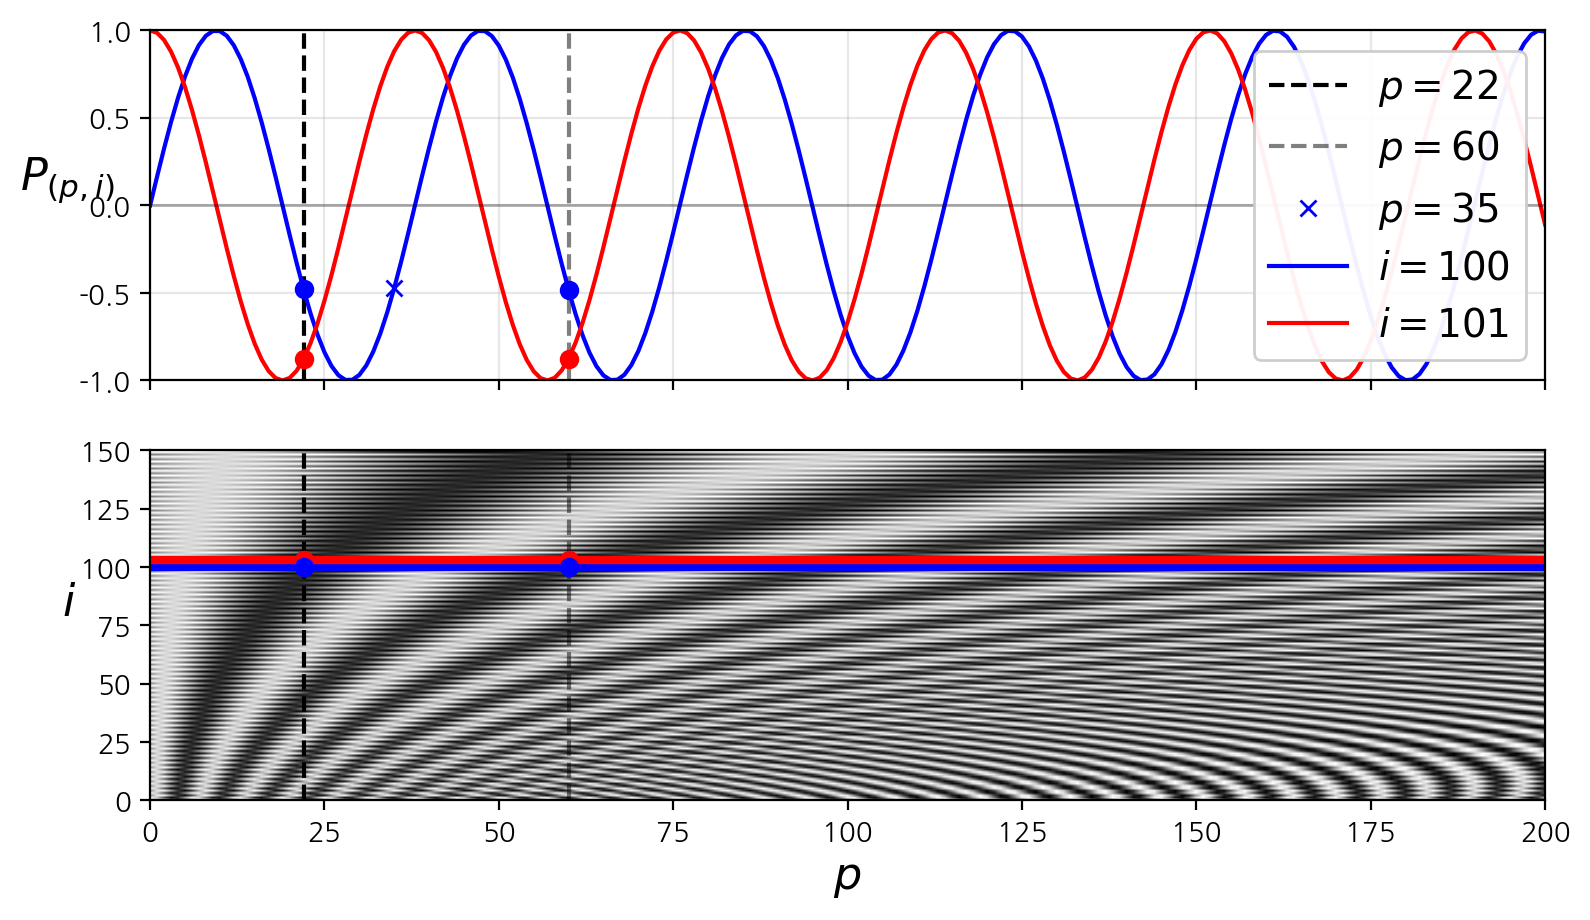

In [94]:
# 그림 16-9를 생성하고 저장하는 코드입니다.

# 위치 인코딩을 시각화하기 위한 파라미터 설정
figure_max_length = 201  # 시각화할 최대 시퀀스 길이
figure_embed_size = 512  # 임베딩 차원

# PositionalEncoding 레이어 생성
pos_emb = PositionalEncoding(figure_max_length, figure_embed_size)

# 0으로 채워진 입력 텐서 생성
zeros = np.zeros((1, figure_max_length, figure_embed_size), np.float32)

# 위치 인코딩 계산
P = pos_emb(zeros)[0].numpy()

# 시각화를 위한 인덱스 설정
i1, i2, crop_i = 100, 101, 150  # 두 개의 임베딩 차원과 시각화할 최대 차원
p1, p2, p3 = 22, 60, 35  # 세 개의 위치

# 그래프 생성
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))

# 상단 그래프: 위치에 따른 인코딩 값 변화
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, P[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(P[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(P[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [P[p1, i1], P[p2, i1]], "bo")
ax1.plot([p1, p2], [P[p1, i2], P[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, figure_max_length - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, figure_max_length - 1, -1, 1])

# 하단 그래프: 위치 인코딩의 히트맵
ax2.imshow(P.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, figure_max_length - 1, color="b", linewidth=3)
cheat = 2  # 빨간 선을 약간 위로 올려 파란 선과 겹치지 않게 함
ax2.hlines(i2+cheat, 0, figure_max_length - 1, color="r", linewidth=3)
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, figure_max_length - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)

# 그래프 저장 및 출력
# save_fig("positional_embedding_plot")
plt.show()

### 멀티 헤드 어텐션

**스케일드 점곱 어텐션 (Scaled Dot-Product Attention)**
- 스케일드 점곱 어텐션은 점곱 어텐션의 확장된 형태로, 어텐션 값의 스케일링을 통해 계산의 안정성을 향상시킵니다. 주된 수식은 다음과 같습니다:

<img src="./images/eq_16_03.png" width=450>

여기서:
- $ Q $ (쿼리 행렬): 크기 $[n_{queries}, d_{keys}]$, 각 행이 하나의 쿼리를 나타냄.
- $ K $ (키 행렬): 크기 $[n_{keys}, d_{keys}]$, 각 행이 하나의 키를 포함.
- $ V $ (값 행렬): 크기 $[n_{keys}, d_{values}]$, 각 행이 하나의 값을 포함.

계산 과정에서 $ QK^T $의 크기는 $[n_{queries}, n_{keys}]$가 되며, 소프트맥스를 취한 후 최종 어텐션 결과의 크기는 $[n_{queries}, d_{values}]$입니다.

**스케일링 인자의 역할**  
- 스케일링 인자 $ \frac{1}{\sqrt{d_{keys}}} $는 소프트맥스 함수에 입력되는 값의 크기를 조정하여, 값이 너무 커질 때 발생할 수 있는 그래디언트 소실 문제를 방지합니다. 이를 통해 모델 학습이 보다 안정적으로 이루어집니다.

**마스킹의 활용**  
- 어텐션 연산에서 특정 위치의 값을 마스킹하기 위해, 소프트맥스 계산 전에 해당 위치 값을 매우 큰 음수로 설정할 수 있습니다. 이는 멀티 헤드 어텐션에서 특정 쿼리와 키의 연산을 제외하는 데 사용됩니다.

**멀티 헤드 어텐션**
- 멀티 헤드 어텐션은 여러 개의 스케일드 점곱 어텐션을 병렬로 수행하여, 입력 데이터에서 다양한 정보와 특성을 학습할 수 있도록 도와줍니다. 각각의 어텐션 헤드는 독립적으로 입력 값 $ Q $, $ K $, $ V $에 대해 선형 변환을 적용한 후 어텐션 연산을 수행하고, 그 결과를 결합하여 최종 출력을 생성합니다. 

**구조적 동기**  
- 멀티 헤드 어텐션을 통해 모델은 다양한 표현 공간에서 입력의 특성에 주목할 수 있습니다. 예를 들어, 문장 "I like soccer"에서 "like"는 문맥에 따라 다른 의미를 가질 수 있습니다. 여러 개의 헤드가 이처럼 다양한 문맥적 특성을 학습하게 되며, 이를 통해 모델의 표현력을 크게 향상시킬 수 있습니다.


<img src="./images/fig_16_10.png" width=800>

**텐서플로우 구현**

텐서플로우에서는 `tf.keras.layers.MultiHeadAttention` 클래스를 사용하여 멀티 헤드 어텐션 층을 쉽게 구현할 수 있습니다. 아래 예제 코드는 드롭아웃과 레이어 정규화 등을 포함한 트랜스포머 모델의 일부입니다.

In [95]:
# 트랜스포머 인코더 구현
N = 2  # 인코더 레이어 수 (원본 구조는 6)
num_heads = 8  # 멀티헤드 어텐션의 헤드 수
dropout_rate = 0.1  # 드롭아웃 비율
n_units = 128  # 피드 포워드 네트워크의 첫 번째 Dense 층의 유닛 개수

# 패딩 마스크 생성 (패딩 토큰(0)이 아닌 부분만 True)
encoder_pad_mask = tf.math.not_equal(encoder_input_ids, 0)[:, tf.newaxis]

Z = encoder_in  # 초기 입력

# N번 반복하여 인코더 레이어 구성
for _ in range(N):
    # 1. 멀티헤드 셀프 어텐션
    skip = Z  # 잔차 연결을 위해 입력 저장
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=encoder_pad_mask)  # 셀프 어텐션 수행
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))  # 잔차 연결 및 층 정규화
    
    # 2. 포지션 와이즈 피드 포워드 네트워크
    skip = Z  # 잔차 연결을 위해 입력 저장
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)  # 첫 번째 Dense 층
    Z = tf.keras.layers.Dense(embed_size)(Z)  # 두 번째 Dense 층
    Z = tf.keras.layers.Dropout(dropout_rate)(Z)  # 드롭아웃 적용
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))  # 잔차 연결 및 층 정규화

위 코드는 두 번의 반복을 통해 멀티 헤드 어텐션 층과 밀집 층을 적용합니다. `LayerNormalization`과 드롭아웃을 사용하여 모델의 일반화와 안정성을 높입니다.

**마스킹 처리**

`MultiHeadAttention` 층에서는 자동으로 마스킹을 적용하지 않기 때문에, 사용자가 직접 `attention_mask`를 설정해야 합니다. 마스킹은 두 가지 방식으로 적용될 수 있습니다.

- **패딩 마스크**: 입력 시퀀스의 패딩 토큰을 무시하기 위해 사용됩니다. 예를 들어, `tf.math.not_equal(encoder_input_ids, 0)`을 이용해 패딩 마스크를 생성할 수 있습니다.
- **코잘 마스크(Causal Mask)**: 미래 시점의 정보를 숨기기 위해 사용되며, `tf.linalg.band_part` 함수를 통해 하삼각행렬 형태로 구현됩니다.


In [96]:
# 디코더 입력에 대한 패딩 마스크 생성
# 0이 아닌 값(실제 토큰)에 대해 True를 반환하고, 패딩(0)에 대해 False를 반환합니다.
decoder_pad_mask = tf.math.not_equal(decoder_input_ids, 0)[:, tf.newaxis]

# 코잘 마스크(인과적 마스크) 생성
# 이는 현재 위치 이후의 토큰들을 마스킹하여 미래 정보를 볼 수 없게 합니다.
causal_mask = tf.linalg.band_part(
    tf.ones((batch_max_len_dec, batch_max_len_dec), tf.bool), -1, 0)
# tf.linalg.band_part 함수는 하삼각행렬을 생성합니다:
# - 첫 번째 인자: 모든 원소가 1인 2D 텐서
# - 두 번째 인자 (-1): 모든 하위 대각선을 유지
# - 세 번째 인자 (0): 주 대각선만 상위로 유지 (즉, 상위 삼각형은 모두 0)

**디코더 구조**

디코더는 패딩 마스크와 코잘 마스크를 모두 사용하는 구조로 설계됩니다. 아래 코드에서는 두 가지 마스킹을 적용하여 디코더 내 어텐션 층을 구성합니다.

In [97]:
# 인코더의 최종 출력을 저장합니다. 이는 디코더에서 사용될 것입니다.
encoder_outputs = Z

# 디코더는 자체 입력으로 시작합니다.
Z = decoder_in

# N번 반복하여 디코더 레이어를 구성합니다.
for _ in range(N):
    # 1. 마스크된 멀티헤드 셀프 어텐션
    skip = Z  # 잔차 연결을 위해 입력 저장
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    # 코잘 마스크와 패딩 마스크를 함께 적용하여 셀프 어텐션 수행
    Z = attn_layer(Z, value=Z, attention_mask=causal_mask & decoder_pad_mask)
    # 잔차 연결 및 층 정규화 적용
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    
    # 2. 인코더-디코더 멀티헤드 어텐션
    skip = Z  # 잔차 연결을 위해 입력 저장
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    # 인코더 출력을 value로 사용하여 어텐션 수행
    Z = attn_layer(Z, value=encoder_outputs, attention_mask=encoder_pad_mask)
    # 잔차 연결 및 층 정규화 적용
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    
    # 3. 포지션 와이즈 피드 포워드 네트워크
    skip = Z  # 잔차 연결을 위해 입력 저장
    # 첫 번째 Dense 층 (활성화 함수: ReLU)
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    # 두 번째 Dense 층
    Z = tf.keras.layers.Dense(embed_size)(Z)
    # 잔차 연결 및 층 정규화 적용
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

이 구조에서 첫 번째 `MultiHeadAttention` 층은 디코더 내 어텐션으로, 과거 정보만 사용하도록 코잘 마스크와 패딩 마스크를 사용합니다. 두 번째 `MultiHeadAttention` 층은 인코더-디코더 어텐션으로, 인코더 출력과 현재 디코더 입력 간의 어텐션을 수행합니다.

**최종 출력층과 모델 구성**

모델의 마지막 단계에서 출력 $ Z $를 어휘 집합의 크기 (`vocab_size`)로 조정하기 위해 `Dense` 층을 추가합니다. 

In [98]:
Y_proba = tf.keras.layers.Dense(vocab_size, activation="softmax")(Z)

**경고**: 다음 셀을 실행하는 데 시간이 걸릴 수 있습니다(GPU를 사용하지 않는 경우 2~3시간 정도 소요될 수 있습니다).

In [101]:
# 모델 파일 경로
model_path = "my_multihead_attention_model"

# 모델이 이미 존재하는지 확인
if os.path.exists(model_path):
    print("모델을 불러옵니다.")
    model = tf.keras.models.load_model(model_path)  # TensorFlow 형식으로 저장된 모델 불러오기
else:
    print("모델을 학습합니다.")
    # 모델 정의
    model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
    model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
                  metrics=["accuracy"])
    
    # 체크포인트 콜백 설정
    model_ckpt = tf.keras.callbacks.ModelCheckpoint(
        model_path,
        monitor="val_accuracy",
        save_best_only=True,
        save_format='tf'  # TensorFlow 형식으로 저장
    )
    
    # 모델 훈련
    model.fit(
        (X_train, X_train_dec),  # 훈련 데이터셋
        Y_train,  # 타깃 데이터셋
        epochs=10,  # 10번의 에폭 동안 훈련
        validation_data=((X_valid, X_valid_dec), Y_valid),  # 검증 데이터셋
        callbacks=[model_ckpt]  # 체크포인트 콜백 추가
    )

모델을 불러옵니다.


In [102]:
translate("I like soccer and also going to the beach")

1/1 [==============================] - 0s 13ms/step


'me gusta el fútbol y también ir a la playa'

**추가 정보**

Keras 팀은 트랜스포머 모델의 구현을 보다 쉽게 하기 위해 `Keras NLP` 프로젝트를 제공하며, 이를 통해 보다 간단한 API로 모델을 구축할 수 있습니다.

이와 같은 과정을 통해 트랜스포머 기반의 자연어 처리 모델을 효율적으로 구현하고 훈련할 수 있습니다.

# 언어 모델 분야의 최근 혁신

**NLP 모델의 발전**  
2018년은 "NLP를 위한 이미지넷 시대"라 불릴 정도로 큰 발전이 이루어졌습니다. 그 이후로는 LSTM과 트랜스포머 기반의 모델이 큰 규모의 데이터셋에서 학습되었습니다.

**GPT와 트랜스포머의 등장**  
알렉 레드포드와 OpenAI 연구자들의 GPT 논문은 이전의 ELMo와 ULMFiT 논문처럼 비지도 사전 훈련의 효과를 보여주었습니다. 하지만 이번에는 트랜스포머와 유사한 구조를 사용했습니다. 이들은 원본 트랜스포머 디코더와 유사한 마스크드 멀티 헤드 어텐션 층을 쌓아 대규모 데이터셋에서 모델을 훈련시켰습니다. 모델은 다양한 작업(텍스트 분류, 수반 관계, 유사성 평가, 질문-답변 등)에 대해 미세 튜닝되었습니다.

**BERT의 등장**  
구글의 BERT 논문은 대규모 텍스트 데이터에서 사전 훈련의 효과를 강조했습니다. GPT와 유사하게 BERT도 멀티 헤드 어텐션 층을 사용했지만, 양방향성을 가진다는 점이 특징입니다. 저자들은 BERT의 강점을 설명하기 위해 두 가지 사전 훈련 작업을 제안했습니다:

1. **마스크드 언어 모델 (Masked Language Model, MLM)**  
   문장에서 임의의 단어를 15% 확률로 마스킹하고, 모델이 이 마스킹된 단어를 예측하도록 학습합니다. 예를 들어, "She had fun at the birthday party"에서 "birthday"가 마스킹되면, 모델은 해당 단어를 추론하도록 학습합니다.

2. **다음 문장 예측 (Next Sentence Prediction, NSP)**  
   두 문장이 연속적인지 아닌지를 예측하는 작업입니다. 예를 들어, "The dog sleeps"와 "It snores loudly"는 연속적인 문장이지만, "The dog sleeps"와 "The Earth orbits the Sun"은 연속적인 문장이 아닙니다. 이후 연구를 통해 이 작업이 NLP 모델의 성능에 중요한 역할을 하지 않는다는 것이 밝혀졌습니다.

**BERT의 사전 훈련 방법**  
BERT는 두 가지 사전 훈련 작업인 마스크드 언어 모델(MLM)과 다음 문장 예측(NSP)을 동시에 수행하여 학습됩니다. 

- **마스크드 언어 모델 (Masked Language Model, MLM)**  
  입력 문장의 일부 단어를 마스킹하고, 모델이 해당 단어가 무엇인지 예측하도록 학습합니다. 손실 함수는 마스킹된 토큰에 대해서만 계산되며, 마스킹되지 않은 토큰은 손실 계산에서 제외됩니다.

- **다음 문장 예측 (Next Sentence Prediction, NSP)**  
  모델이 두 문장이 연속적인지 아닌지를 예측하는 작업입니다. 이 작업을 위해 입력 텍스트의 시작 부분에 특별한 클래스 토큰([CLS])을 추가하고, 두 입력 문장을 분리하는 구분 토큰([SEP])을 사용합니다.

**세그먼트 임베딩 (Segment Embedding)**  
각 입력 토큰이 어느 문장에 속하는지 모델에 알려주기 위해 세그먼트 임베딩이 추가됩니다. 이는 문장 A와 문장 B를 구분하는 데 사용됩니다.

**그림 16-11: BERT 훈련과 미세 튜닝 과정**  
그림에서는 BERT의 훈련 단계와 미세 튜닝 단계를 시각적으로 설명하고 있습니다.

1. **사전 훈련**  
   - MLM과 NSP 작업이 동시에 이루어집니다. 마스킹된 단어 예측과 두 문장의 연속성 여부 예측을 통해 모델이 언어 구조를 학습하게 됩니다.

2. **미세 튜닝**  
   - 사전 훈련된 모델을 바탕으로 다양한 작업(예: 감성 분석, 질문-답변 등)에서 모델을 조금씩 바꾸면서 미세 튜닝합니다. 이 과정에서 감정 분석과 같은 텍스트 분류 작업에서는 첫 번째 출력 토큰([CLS])만 사용되고, 질문-답변 작업에서는 특정 시작과 끝 위치의 출력을 기반으로 답변 범위를 예측합니다.

**사전 훈련 후 미세 튜닝의 중요성**  
BERT는 대규모 텍스트 말뭉치에서 비지도 사전 훈련을 거친 후 다양한 다운스트림 작업에서 미세 튜닝을 통해 성능을 향상시킵니다. 이는 NLP 모델이 다양한 태스크에 적응할 수 있도록 도와줍니다.

<img src="./images/fig_16_11.png" width=800>

**GPT-2의 등장과 제로 샷 학습 (Zero-Shot Learning)**  
BERT가 발표된 이후, 2019년 2월 알렉 레드포드, 제프리 우, 그리고 OpenAI 연구팀은 GPT-2 모델을 발표했습니다. GPT-2는 GPT와 구조가 유사하지만, 훨씬 더 큰 규모(15억 개 이상의 파라미터)로 구성되었습니다. 이 모델은 미세 튜닝 없이 다양한 작업을 수행할 수 있는 제로 샷 학습 능력을 보여주었으며, 이는 대규모 모델을 향한 경쟁의 시작을 알리는 계기가 되었습니다.

**대규모 트랜스포머 모델의 확대**  
2021년 1월에는 구글의 스위치 트랜스포머(Switch Transformer)가 1조 개의 파라미터를 사용하여 기존 모델보다 훨씬 큰 규모로 등장했습니다. 같은 해 6월에는 베이징 인공지능 아카데미(BAII)의 Wu Dao 2.0 모델이 발표되었으며, 이 역시 대규모 트랜스포머 모델의 하나로 자리 잡았습니다.

**대규모 모델의 문제점과 해결 방안**  
대규모 모델을 훈련하는 것은 막대한 비용과 에너지가 필요하며, 이는 환경에 부정적인 영향을 미칠 수 있습니다. 이러한 문제를 해결하기 위해 연구자들은 트랜스포머의 크기를 줄이거나 데이터 효율성을 높이는 방법을 모색하고 있습니다.

**DistilBERT의 등장**  
2019년 10월, 허깅 페이스의 빅터 산과 연구팀은 BERT의 경량화 버전인 DistilBERT를 소개했습니다. DistilBERT는 "증류(distillation)"라는 방법을 사용하여 학습되었는데, 이는 큰 모델(티처 모델)의 지식을 작은 모델(스튜던트 모델)에 전이하는 것을 의미합니다. DistilBERT는 BERT와 동일한 데이터셋으로 훈련되지만, 모델 크기와 연산량을 줄이면서도 성능을 유지할 수 있습니다.

**증류 학습의 효과**  
증류 학습에서는 티처 모델이 훈련 샘플에 대해 예측한 확률을 스튜던트 모델의 타깃으로 사용합니다. 이 방식은 일반적인 레이블로 학습하는 것보다 더 많은 정보량을 전달할 수 있어, 작은 모델에서도 높은 성능을 얻을 수 있습니다.

**BERT 이후의 트랜스포머 모델 발전**  
BERT가 발표된 이후, 다양한 트랜스포머 구조가 출시되며 NLP 기술이 크게 향상되었습니다. 대표적인 모델로는 다음과 같습니다:
- **XLNet (2019년 6월)**
- **RoBERTa (2019년 7월)**
- **StructBERT (2019년 8월)**
- **ALBERT (2019년 9월)**
- **T5 (2019년 10월)**
- **ELECTRA (2020년 3월)**
- **GPT-3 (2020년 5월)**
- **DeBERTa (2020년 6월)**
- **스위치 트랜스포머 (2021년 1월)**
- **Wu Dao 2.0 (2021년 6월)**
- **Gopher (2021년 12월)**
- **GPT-NeoX-20B (2022년 2월)**
- **Chinchilla (2022년 3월)**
- **OPT (2022년 5월)**

이들 모델은 새로운 아이디어와 기술을 도입하며 NLP 성능을 지속적으로 개선해왔습니다.

**T5 모델의 특징**  
구글 연구팀의 T5 모델은 특히 인코더-디코더 트랜스포머를 기반으로 한 "텍스트-투-텍스트" 접근 방식을 도입했습니다. 모든 NLP 작업을 입력과 출력이 텍스트 형태인 문제로 구조화하여 처리합니다.

- 예를 들어, "I like soccer"를 스페인어로 번역하려면, 입력을 "translate English to Spanish: I like soccer"로 작성합니다. 그러면 모델은 "me gusta el fútbol"이라는 결과를 생성합니다.
- 텍스트 요약의 경우, 문장 뒤에 "summarize:"를 추가하면 요약 결과가 출력됩니다.
- 텍스트 분류의 경우, 입력 앞에 "classify:"를 추가하면 모델이 해당 클래스 이름을 출력합니다.

**Pathways와 PaLM의 특징**  
Pathways는 대규모 모델 훈련을 위한 새로운 플랫폼으로, 6,000개 이상의 TPU를 사용해 5,400억 개의 파라미터를 가진 언어 모델인 PaLM을 학습했습니다. PaLM은 마스크드 멀티 헤드 어텐션 층을 사용하는 표준 트랜스포머 구조를 기반으로 하며, NLP 작업, 특히 자연어 이해(NLU) 작업에서 뛰어난 성능을 발휘했습니다.

**사고 사슬 프롬프트 (Chain of Thought Prompting)**  
PaLM의 성능 향상에는 "사고 사슬 프롬프트" 기술이 기여했습니다. 이 기술은 모델이 문제 해결 과정을 단계별로 설명하고 답을 도출하도록 유도합니다. 예를 들어, 기본적인 산수 문제에서도 일반적인 프롬프트를 사용하는 것보다 사고 사슬 프롬프트를 통해 중간 단계를 명확히 설명하며 문제를 풀도록 합니다.

**사례 예시**  
1. **기본 프롬프트 예시**:  
   - 질문: "로저는 테니스 공 5개를 가지고 있습니다. 그는 테니스 공 2캔을 더 샀습니다. 각 캔에는 테니스 공이 3개씩 들어 있습니다. 이제 로저는 몇 개의 테니스 공을 가지고 있나요?"  
   - 모델의 답변: 11 (단계별 설명 없이 답을 바로 제시).

2. **사고 사슬 프롬프트 예시**:  
   - 질문: "존은 개 10마리를 돌보고 있습니다. 각 개를 산책시키고 돌보는 데 하루에 0.5시간이 걸립니다. 그는 일주일에 개를 돌보는 데 몇 시간을 소비하나요?"  
   - 사고 사슬 프롬프트를 사용하면, 모델은 계산 과정을 단계별로 설명하면서 "주 35시간"이라는 답을 도출합니다.

**사고 사슬 프롬프트의 장점**  
일반적인 프롬프트보다 사고 사슬 프롬프트를 사용할 때, 모델이 문제 해결 과정의 각 단계에서 정확하게 답변을 제시할 확률이 높아집니다. 이는 단순히 답만 제시하는 것이 아니라, 모델이 도출한 답의 근거를 명확하게 설명할 수 있어 신뢰성 있는 결과를 제공하는 데 유리합니다.

# 비전 트랜스포머

첨부된 내용은 **비전 트랜스포머**에 대한 설명과, 어텐션 메커니즘이 이미지 캡션 생성에서 어떻게 활용되는지를 다루고 있습니다. 주요 내용은 다음과 같습니다:

**비전 트랜스포머와 어텐션 메커니즘의 적용**  
비전 트랜스포머는 NMT(기계 번역) 이후 처음으로 비주얼 어텐션을 활용한 사례입니다. 이미지 캡션 생성에 어텐션 메커니즘을 사용하여, 합성곱 신경망(CNN)이 이미지를 처리한 후 어텐션 메커니즘을 통해 디코더 RNN이 단어별로 캡션을 생성합니다.

**디코더 타임 스텝에서의 어텐션**  
디코더는 매 타임 스텝(단어마다)에서 어텐션 메커니즘을 사용하여 이미지의 적절한 부분에 초점을 맞춥니다. 예를 들어, "A woman is throwing a frisbee in a park"라는 캡션을 생성할 때, "frisbee"를 출력할 시점에는 이미지에서 해당 부분에 집중하게 됩니다. 그림 16-12에서는 입력 이미지와 모델이 "frisbee"를 생성하기 전 초점을 맞춘 부분을 시각화하고 있습니다.

<img src="./images/fig_16_12.png" width=800>

**설명 가능성 (Explainability)**  
어텐션 메커니즘의 장점 중 하나는 모델의 출력이 어떻게 도출되었는지를 이해하기 쉽게 한다는 점입니다. 이를 설명 가능성이라고 하며, 특히 모델이 예상치 못한 결과를 도출했을 때 유용합니다. 예를 들어, "눈 위를 걷는 강아지" 사진에 대해 모델이 "눈 위를 걷는 늑대"라는 캡션을 생성했다면, 모델이 왜 그렇게 판단했는지 어텐션을 통해 확인할 수 있습니다. 

어텐션을 통해 모델이 어디에 초점을 맞추고 있는지 파악할 수 있으며, 이를 통해 결과의 타당성을 검토하거나 모델의 성능을 개선할 수 있습니다. 예를 들어, 모델이 강아지와 늑대를 구분하기 위해서 눈 속에 있는 늑대 사진과 강아지 사진을 많이 사용하여 학습할 수 있습니다.

**설명 가능성의 활용**  
설명 가능성은 모델의 대개를 넘어서 법적 요구 사항을 충족하거나 대출 자격을 부여하는 시스템 같은 분야에서도 중요한 역할을 합니다.

**트랜스포머의 이미지 처리로의 확장**  
트랜스포머는 2017년에 NLP 작업에 처음 도입된 이후, 이미지 캡션 생성과 같은 컴퓨터 비전 작업에서도 시도되었습니다. 초기에는 기존의 CNN(합성곱 신경망)과 결합하여 하이브리드 CNN-트랜스포머 구조로 사용되었으며, 트랜스포머는 RNN 대신 이미지의 특성 맵을 처리하는 데 사용되었습니다. 페이스북 연구팀은 2020년 논문에서 이러한 하이브리드 구조를 제안했습니다.

**비전 트랜스포머 (ViT)의 등장**  
2020년 10월, 구글 연구팀은 완전한 트랜스포머 기반 비전 모델인 비전 트랜스포머(ViT)를 발표했습니다. ViT는 기존 CNN 대신 트랜스포머를 사용하여 이미지를 처리하는 방식으로, 이미지의 각 패치를 16×16 크기로 분할하여 벡터화한 후, 이를 시퀀스 데이터처럼 트랜스포머에 입력합니다. 각 패치 벡터는 768차원(16×16×3, RGB 채널)으로 표현됩니다.

**ViT의 처리 과정**  
1. **패치 분할**: 입력 이미지를 16×16 패치로 분할하여 벡터화.
2. **위치 임베딩**: 패치의 위치 정보를 추가하여 시퀀스 처리.
3. **트랜스포머 입력**: 시퀀스 데이터를 트랜스포머 구조에 전달하여 학습.

이 방식은 기존 CNN을 대체하여도 이미지 분류 작업에서 뛰어난 성능을 보였지만, ViT의 훈련에는 대규모 데이터셋이 필요했습니다. 구글 연구팀은 3억 개 이상의 이미지 데이터를 추가로 사용해 ViT를 훈련했습니다.

**귀납적 편향 (Inductive Bias)와 CNN**  
트랜스포머는 귀납적 편향이 부족하여, CNN처럼 지역적 특성 학습을 효율적으로 수행하지 못합니다. 귀납적 편향은 모델의 구조가 특정 학습 패턴을 내재적으로 가정하는 것을 의미합니다. 예를 들어, CNN은 이미지의 공간적 구조를 학습할 때 유리하지만, 트랜스포머는 더 많은 데이터를 필요로 합니다.
결론적으로, ViT는 기존 CNN을 대체할 가능성을 보여주었지만, 대규모 데이터셋을 통해서만 성능이 발휘되는 한계를 갖고 있습니다.

**DeiT (Data-Efficient Image Transformer)**  
페이스북 연구팀은 2021년에 추가적인 훈련 데이터 없이도 이미지넷에서 경쟁력 있는 성능을 달성할 수 있는 "데이터 효율적인 이미지 트랜스포머" (DeiT) 모델을 발표했습니다. DeiT는 ViT(비전 트랜스포머)와 거의 동일한 구조를 가지지만, 최신 CNN 모델에서 얻은 지식을 트랜스퍼 러닝을 통해 모델에 적용함으로써 데이터 사용의 효율성을 높였습니다.

**퍼시비어 (Perceiver)**  
2021년 3월, 딥마인드는 퍼시비어(Perceiver) 모델을 발표했습니다. 퍼시비어는 멀티모달 트랜스포머로, 텍스트, 이미지, 오디오 등 다양한 유형의 데이터를 입력할 수 있습니다. 기존 트랜스포머 모델은 시퀀스의 길이가 길어지면 어텐션 계산의 복잡도가 증가하는 문제를 가지고 있었습니다. 이를 해결하기 위해 퍼시비어는 짧은 입력의 잠재 표현(latent representation)을 통해 계산 복잡도를 줄이는 방식을 도입했습니다.

- **잠재 표현과 크로스 어텐션**  
  퍼시비어는 입력 시퀀스의 모든 토큰 대신, 잠재 표현을 사용하여 어텐션을 수행합니다. 이는 크로스 어텐션 층을 사용하여 잠재 표현과 입력 간의 연관성을 학습합니다. 크로스 어텐션 층은 입력의 크기에 비례하지 않으므로 효율적이며, RNN처럼 시계열 처리를 할 수 있습니다.

**DINO (Self-Distillation with No Labels)**  
마틸드 카론 등의 연구팀은 DINO라는 새로운 비전 트랜스포머 모델을 소개했습니다. DINO는 자기 지도 학습을 통해 레이블 없이도 높은 정확도로 이미지를 학습할 수 있습니다. 

- **자기 증류 (Self-Distillation)**  
  DINO는 교사 네트워크와 학생 네트워크의 역할을 하는 두 개의 모델을 동시에 훈련합니다. 교사 모델의 예측은 이동 평균을 통해 학생 모델에 전이됩니다. 두 모델은 입력을 완전히 무시하고 항상 같은 출력을 피하도록 설계되어 있으며, 이를 위해 "모드 붕괴"를 방지하고, 예측의 다양성을 유지하기 위해 출력에 샤프닝(sharpening)을 적용합니다.

**데이터 효율성을 위한 ViT 확장 연구**  
2021년 구글 연구팀은 데이터 양에 따라 비전 트랜스포머(ViT)의 성능을 확장하거나 축소하는 방법을 연구했습니다. 20억 개의 파라미터를 가진 대규모 모델을 통해 이미지넷에서 90.4% 이상의 정확도를 달성했으며, 데이터가 적은 상황에서도 성능이 우수한 모델을 제시했습니다. 예를 들어, 10,000개의 이미지로만 훈련된 모델이 84.8%의 정확도를 달성했습니다.

**비전 트랜스포머의 지속적 발전**  
2022년 3월에 발표된 논문에서는 여러 트랜스포머를 먼저 학습시키고 그 가중치를 평균화하여 새로운 모델을 생성할 수 있음을 보여주었습니다. 이 방법은 모델 학습 시간을 줄이면서도 성능을 유지하는 데 유리한 접근 방식입니다.

**제로 샷 및 퓨 샷 학습의 트렌드**  
트랜스포머의 최신 트렌드는 제로 샷 학습과 퓨 샷 학습을 가능하게 하는 대규모 멀티모달 모델의 개발입니다.  
- **CLIP (2021년 OpenAI)**: 캡션과 이미지를 함께 학습하여 제로 샷 이미지 분류와 같은 작업을 수행할 수 있는 모델입니다. 간단한 텍스트 프롬프트로 이미지 분류를 실행할 수 있습니다.
- **DALL-E 2 (OpenAI)**: 확산 모델을 사용하여 높은 품질의 이미지를 생성할 수 있습니다.

**플라밍고 (Flamingo)와 GATO**  
2022년 4월, 딥마인드는 텍스트, 이미지, 동영상 등 다양한 데이터 형식에 대한 사전 훈련된 멀티모달 모델인 플라밍고를 발표했습니다. 이 모델은 이미지 캡션 생성이나 로봇 제어 등 여러 작업에 사용할 수 있습니다. 이어서 2022년 5월에는 강화 학습을 위한 멀티모달 모델 GATO를 출시했습니다. GATO는 단일 트랜스포머 모델로 채팅, 게임 플레이, 로봇 제어 등의 다양한 작업을 수행할 수 있습니다.

**규모가 곧 성능 (Scale is all you need)라는 접근**  
모델의 규모를 확장함으로써 인간 수준의 인지 능력에 도달할 수 있다는 연구자들의 주장이 있습니다. 하지만 이러한 모델의 성능은 여전히 인간의 일반화 능력이나 직관적인 신뢰성에는 미치지 못합니다.

# 허깅 페이스의 트랜스포머스 라이브러리

허깅 페이스는 자연어 처리와 비전 등 다양한 작업에 쉽게 활용할 수 있는 오픈 소스 도구 생태계를 제공합니다. 이 라이브러리는 사전 훈련된 모델과 토크나이저를 쉽게 다운로드하여 사용할 수 있으며, 텐서플로, 파이토치, JAX(Flax 라이브러리)를 지원합니다. 

**`transformers.pipeline()` 함수의 사용**  
트랜스포머 라이브러리를 사용하는 가장 간단한 방법은 `transformers.pipeline()` 함수를 활용하는 것입니다. 이 함수는 감정 분석, 개체명 인식, 요약 등 다양한 작업을 수행할 수 있습니다. 

다음은 감정 분석을 수행하는 예제 코드입니다:

In [103]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")  # 다른 많은 작업을 사용할 수 있습니다.
result = classifier("The actors were very convincing.")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/home/restful3/anaconda3/envs/handson/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

위 코드에서 `pipeline` 함수는 감정 분석(`sentiment-analysis`) 모델을 불러와서 입력 문장에 대해 긍정적인지 부정적인지를 판별합니다.

In [104]:
result

[{'label': 'POSITIVE', 'score': 0.9998071789741516}]

모델은 약 99.98%의 신뢰도로 해당 문장이 긍정적임을 판단합니다.

**배치 처리 예시**  
여러 문장을 동시에 분석할 수도 있습니다:

In [105]:
classifier(["I am from India.", "I am from Iraq."])

[{'label': 'POSITIVE', 'score': 0.9896161556243896},
 {'label': 'NEGATIVE', 'score': 0.9811071157455444}]

이 예시에서는 첫 번째 문장은 긍정, 두 번째 문장은 부정으로 분류되었습니다. 

>**편향과 공정성**
>- **편향 문제**: 훈련 데이터에 포함된 특정 국가나 사건에 대한 부정적인 내용 때문에, 모델이 편향된 예측을 할 수 있습니다.
>- **해결 노력**: 클래스 균형 조정이나 데이터 수정으로 편향을 줄일 수 있지만, 완전한 해결책은 아닙니다.
>- **성능 평가**: 모델의 평균 성능뿐만 아니라 다양한 상황에서의 성능을 평가해야 하며, 반사실 테스트를 통해 예측의 공정성을 검증할 수 있습니다.
>- **전략 제안**: 모델 배포 전 공정성 평가, 데이터 균형 조정, 하이퍼파라미터 튜닝 등을 통해 편향을 완화해야 합니다.

**`pipeline()` 함수 사용**  
- `pipeline()` 함수는 지정된 작업에 맞는 기본 모델을 불러와서 사용할 수 있습니다. 예를 들어, 감정 분석 작업에서는 기본적으로 `distilbert-base-uncased-finetuned-sst-2-english` 모델이 사용됩니다.
- 모델을 직접 지정할 수도 있으며, 예를 들어 MultiNLI 작업에서 두 문장을 비교하여 모순, 중립, 함의의 세 클래스로 분류할 수 있습니다.

다음은 MultiNLI 작업에 미세 튜닝된 DistilBERT 모델을 사용하는 코드입니다:

In [106]:
# MultiNLI 작업을 위한 모델 이름 지정
model_name = "huggingface/distilbert-base-uncased-finetuned-mnli"

# 텍스트 분류 파이프라인 생성
# 지정된 모델을 사용하여 MultiNLI 작업 수행
classifier_mnli = pipeline("text-classification", model=model_name)

# 두 문장 간의 관계 분류
# [SEP] 토큰은 두 문장을 구분하는 역할
result = classifier_mnli("She loves me. [SEP] She loves me not.")

# 결과 출력
print(result)

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[{'label': 'contradiction', 'score': 0.9790192246437073}]

위 코드의 결과는 주어진 문장이 모순(`contradiction`) 관계임을 나타내며, 신뢰도 점수를 제공합니다.

**직접 모델과 토크나이저를 사용하는 방법**  
`pipeline()` 함수 대신 더 세밀한 제어가 필요할 경우, 트랜스포머 라이브러리의 클래스를 직접 사용할 수 있습니다.

- 예를 들어, `TFAutoModelForSequenceClassification`과 `AutoTokenizer`를 사용하여 모델과 토크나이저를 로드하고, 입력 문장을 토큰화할 수 있습니다.

In [107]:
# transformers 라이브러리에서 필요한 클래스들을 가져옵니다
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# 사전 훈련된 토크나이저를 불러옵니다
# 이 토크나이저는 입력 텍스트를 모델이 이해할 수 있는 형태로 변환합니다
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 사전 훈련된 모델을 불러옵니다
# 이 모델은 시퀀스 분류 작업을 수행할 수 있도록 설계되었습니다
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

# 참고: model_name은 이전에 정의된 변수로, 사용할 특정 모델의 이름을 나타냅니다
# 이 경우 "huggingface/distilbert-base-uncased-finetuned-mnli" 모델을 사용합니다

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


- 토크나이저를 사용해 문장을 텐서로 변환하고, 패딩을 활성화할 수 있습니다.

In [108]:
# 토크나이저를 사용하여 입력 문장을 토큰화합니다
token_ids = tokenizer(
    # 두 쌍의 문장을 입력으로 제공합니다
    ["I like soccer. [SEP] We all love soccer!",
     "Joe lived for a very long time. [SEP] Joe is old."],
    padding=True,  # 문장의 길이를 맞추기 위해 패딩을 적용합니다
    return_tensors="tf"  # 텐서플로우 텐서 형식으로 반환합니다
)

# 토큰화된 결과를 출력합니다
# 이는 input_ids(토큰 ID)와 attention_mask(패딩 정보)를 포함합니다
token_ids

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214, 1012,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

**BatchEncoding 객체**  
토크나이저를 사용해 입력 텍스트를 토큰화하면, `BatchEncoding` 객체가 생성됩니다. 이 객체는 토큰 ID와 패딩된 시퀀스, 마스킹 정보 등을 포함합니다.


In [109]:
# 토크나이저를 사용하여 문장 쌍을 토큰화합니다
token_ids = tokenizer([("I like soccer.", "We all love soccer!"),  # 첫 번째 문장 쌍
                       ("Joe lived for a very long time.", "Joe is old.")],  # 두 번째 문장 쌍
                      padding=True,  # 문장 길이를 맞추기 위해 패딩을 적용합니다
                      return_tensors="tf")  # TensorFlow 텐서 형식으로 반환합니다

# 토큰화된 결과를 출력합니다
# 이는 input_ids(토큰 ID)와 attention_mask(패딩 정보)를 포함합니다
token_ids

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214, 1012,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

여기서 `input_ids`는 입력 토큰의 ID 시퀀스이며, `attention_mask`는 패딩된 위치를 나타내는 마스크입니다.

**추가 설정**  
토크나이저 호출 시 `return_token_type_ids=True`를 설정하면, 각 토큰이 어느 문장에 속하는지를 나타내는 추가 정보도 얻을 수 있습니다. 이는 일부 모델에서 필요할 수 있지만, DistilBERT 모델에서는 필수적이지 않습니다.

**모델 예측 수행**  
`BatchEncoding` 객체를 모델에 입력하여 예측을 수행하면, `TFSequenceClassifierOutput` 객체가 반환됩니다. 이 객체는 각 클래스에 대한 로짓(logit) 값을 포함합니다.

In [110]:
# 모델에 토큰화된 입력을 전달하여 예측을 수행합니다
outputs = model(token_ids)

# 모델의 출력 결과를 표시합니다
# 이는 TFSequenceClassifierOutput 객체로, 로짓 값 등의 정보를 포함합니다
outputs

# 참고: 
# - 'outputs.logits'에는 각 클래스에 대한 원시 점수(로짓)가 포함됩니다
# - 'outputs.hidden_states'와 'outputs.attentions'는 모델 구성에 따라 
#   중간 레이어의 출력과 어텐션 가중치를 포함할 수 있습니다 (이 경우 None일 수 있음)

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-2.1123812 ,  1.1786778 ,  1.4101012 ],
       [-0.01478475,  1.0962486 , -0.9919953 ]], dtype=float32)>, hidden_states=None, attentions=None)

**소프트맥스와 argmax 적용**  
로짓 값에 소프트맥스 활성화 함수를 적용해 클래스 확률로 변환하고, `argmax()`를 사용해 가장 높은 확률을 가진 클래스를 예측할 수 있습니다.

In [111]:
# 모델의 출력 로짓에 소프트맥스 함수를 적용하여 확률 분포로 변환합니다
Y_probas = tf.keras.activations.softmax(outputs.logits)

# 각 클래스에 대한 확률을 출력합니다
# 결과는 2x3 텐서로, 각 행은 하나의 입력에 대한 3개 클래스의 확률을 나타냅니다
# 0: 모순(contradiction), 1: 함의(entailment), 2: 중립(neutral)
Y_probas

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.01619703, 0.4352354 , 0.54856753],
       [0.22655931, 0.68817294, 0.08526774]], dtype=float32)>

In [112]:
# 확률 분포에서 가장 높은 확률을 가진 클래스의 인덱스를 찾습니다
Y_pred = tf.argmax(Y_probas, axis=1)

# 예측 결과를 출력합니다
# 0: 모순(contradiction), 1: 함의(entailment), 2: 중립(neutral)
Y_pred  

# 이 결과는 각 입력 문장 쌍에 대해 모델이 예측한 관계를 나타냅니다
# 예를 들어, [2, 1]이 출력된다면:
# - 첫 번째 문장 쌍은 중립(neutral) 관계로 예측
# - 두 번째 문장 쌍은 함의(entailment) 관계로 예측된 것입니다

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 1])>

이 예에서는 첫 번째 문장이 "모순", 두 번째 문장이 "함의"로 분류됩니다.

**모델 미세 튜닝**  
- 모델을 미세 튜닝하려면 `sparse_categorical_crossentropy` 대신 `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)` 손실 함수를 사용해야 합니다. 이는 모델이 로짓 값을 출력하기 때문입니다.
- `BatchEncoding` 입력을 지원하지 않는 일반 케라스 모델에서는 `data` 속성을 사용해 입력 데이터를 준비해야 합니다.


다음은 간단한 문장 쌍 분류를 위한 코드 예시입니다:

In [113]:
# 문장 쌍 정의
sentences = [("Sky is blue", "Sky is red"), ("I love her", "She loves me")]

# 토크나이저를 사용하여 문장을 토큰화하고 텐서로 변환
X_train = tokenizer(sentences, padding=True, return_tensors="tf").data

# 레이블 정의 (0: 모순, 2: 중립)
y_train = tf.constant([0, 2])  # 첫 번째 쌍은 모순, 두 번째 쌍은 중립

# 손실 함수 정의 (로짓 값을 직접 사용하므로 from_logits=True)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 모델 컴파일
model.compile(
    loss=loss,  # 위에서 정의한 손실 함수 사용
    optimizer="nadam",  # Nadam 옵티마이저 사용
    metrics=["accuracy"]  # 정확도를 평가 지표로 사용
)

# 모델 훈련
history = model.fit(X_train, y_train, epochs=2)  # 2 에포크 동안 훈련

Epoch 1/2
1/1 [==============================] - 17s 17s/step - loss: 0.6666 - accuracy: 0.5000
Epoch 2/2
1/1 [==============================] - 0s 27ms/step - loss: 0.3429 - accuracy: 1.0000


**허깅 페이스 데이터셋 라이브러리**  
허깅 페이스는 표준 데이터셋(예: IMDb)과 사용자 정의 데이터셋을 쉽게 다운로드하고 사용할 수 있는 `데이터셋(Datasets)` 라이브러리를 제공합니다. 이를 통해 텐서플로 데이터셋과 유사한 방식으로 데이터 작업을 수행할 수 있습니다.

**허깅 페이스의 문서 및 자료**  
허깅 페이스의 [문서](https://huggingface.co/docs)와 튜토리얼 노트북, 동영상 등을 참고하여 더 깊이 있는 내용을 학습할 수 있습니다. 또한, 허깅 페이스 팀이 작성한 책 *트랜스포머를 활용한 자연어 처리*도 추천됩니다.

# 연습문제

## 1

문제 : 상태가 없는 RNN 대비 상태가 있는 RNN의 장단점은 무엇인가요?

**상태가 없는 RNN vs. 상태가 있는 RNN**  
   - 상태가 없는 RNN은 짧은 패턴을 감지할 수 있지만, 장기 패턴을 감지하기에는 한계가 있습니다. 반면 상태가 있는 RNN은 장기 패턴을 감지할 수 있지만, 데이터셋을 잘 준비하고 훈련해야 하며 항상 좋은 성능을 보장하지는 않습니다.

## 2

문제 : 왜 자동 번역에 시퀀스-투-시퀀스 RNN 대신 인코더-디코더 RNN을 사용하는가요?

**자동 번역에서 인코더-디코더 RNN을 사용하는 이유**  
   - 시퀀스-투-시퀀스 RNN은 실시간 번역처럼 한 단어씩 즉시 번역하지만, 인코더-디코더 RNN은 전체 문장을 읽고 나서 번역하므로 더 자연스러운 번역이 가능합니다.

## 3

문제 : 가변 길이 입력 시퀀스를 어떻게 다룰 수 있나요? 가변 길이 출력 시퀀스는 어떤가요?


**가변 길이 시퀀스 처리**  
   - 배치 내 시퀀스의 길이가 다를 경우, 패딩을 추가해 길이를 맞추고, 짧은 시퀀스의 토큰은 손실 함수 계산에서 무시할 수 있습니다. 또한, 비슷한 길이의 시퀀스를 묶어 배치로 만드는 것이 효율적입니다.

## 4

문제 : 빕 서치가 무엇인가요? 왜 사용해야 하나요? 이를 구현하기 위해 어떤 도구를 사용할 수 있나요?


**빔 서치**  
   - 훈련된 인코더-디코더 모델의 성능을 높이기 위한 기법으로, 여러 개의 가능한 출력 시퀀스를 생성한 후 가장 가능성이 높은 시퀀스를 선택하는 방식입니다. 파라미터 $ k $를 설정해 탐색 범위를 조절할 수 있습니다.

## 5

문제 : 어텐션 메커니즘이 무엇인가요? 어떤 장점이 있나요?


**어텐션 메커니즘**  
   - 인코더-디코더 모델에서 디코더가 입력 시퀀스의 중요한 부분에 접근할 수 있도록 돕는 기법입니다. 입력의 각 부분과 현재 디코더 타임 스텝 간의 정렬 점수(alignment score)를 계산하여 가장 관련성이 높은 정보에 가중치를 부여합니다. 어텐션의 주요 장점은 긴 입력 시퀀스를 효과적으로 처리하고, 모델이 오류를 분석하는 데 도움을 줄 수 있다는 것입니다. 

## 6

문제 : 트랜스포머 구조에서 가장 중요한 층이 무엇인가요? 이 층의 목적이 무엇인가요?

**트랜스포머 구조에서 가장 중요한 층: 멀티 헤드 어텐션**  
   - 트랜스포머의 핵심 구성 요소 중 하나로, 여러 개의 어텐션을 병렬로 수행해 문맥 정보를 반영합니다. 이를 통해 모델은 단어 간의 상호 관련성을 구분하여 표현할 수 있습니다.

## 7

문제 : 샘플링 소프트맥스를 사용해야 할 때는 언제인가요?

**샘플링 소프트맥스**  
   - 클래스 수가 많은 분류 문제에서 사용되며, 예측된 로짓을 기반으로 크로스 엔트로피 손실의 근사치를 계산합니다. 훈련 속도를 높이고, 모든 로짓에 대해 소프트맥스를 계산하는 일반적인 방식 대신 일부만 추정할 때 유용합니다.

## 8.

문제: 호크라이터와 슈미트후버는 LSTM에 관한 [논문](https://homl.info/93)에서 임베딩된 레버 문법을 사용했습니다. 이는 ‘BPBTSXXVPSEPE’와 같은 문자열을 만드는 인공 문법입니다. 이 주제에 대한 제니 오어의 훌륭한 소개(https://homl.info/108)를 확인해보세요. 특정 임베딩된 레버 문법 하나를 선택하고(제니 오어의 페이지에 있는 것과 같은), 그다음에 문자열이 이 문법을 따르는지 아닌지 구별하는 RNN을 훈련해보세요. 먼저 문법에 맞는 문자열 50%와 그렇지 않은 문자열 50%를 담은 훈련 배치를 생성하는 함수를 만들어야 합니다._

먼저 문법에 맞는 문자열을 생성하는 함수가 필요합니다. 이 문법은 각 상태에서 가능한 전이 상태의 리스트입니다. 하나의 전이는 출력할 문자열(또는 생성할 문법)과 다음 상태를 지정합니다.

In [ ]:
# 기본 레버 문법 정의
default_reber_grammar = [
    [("B", 1)],           # 상태 0에서 'B'를 출력하고 상태 1로 이동
    [("T", 2), ("P", 3)], # 상태 1에서 'T'를 출력하고 상태 2로, 또는 'P'를 출력하고 상태 3으로 이동
    [("S", 2), ("X", 4)], # 상태 2에서 'S'를 출력하고 상태 2로 돌아가거나, 'X'를 출력하고 상태 4로 이동
    [("T", 3), ("V", 5)], # 상태 3에서 'T'를 출력하고 상태 3으로 돌아가거나, 'V'를 출력하고 상태 5로 이동
    [("X", 3), ("S", 6)], # 상태 4에서 'X'를 출력하고 상태 3으로, 또는 'S'를 출력하고 상태 6으로 이동
    [("P", 4), ("V", 6)], # 상태 5에서 'P'를 출력하고 상태 4로, 또는 'V'를 출력하고 상태 6으로 이동
    [("E", None)]]        # 상태 6에서 'E'를 출력하고 종료

# 임베디드 레버 문법 정의
embedded_reber_grammar = [
    [("B", 1)],                    # 시작: 'B' 출력 후 상태 1로
    [("T", 2), ("P", 3)],          # 'T' 또는 'P' 선택
    [(default_reber_grammar, 4)],  # 기본 레버 문법 삽입 후 상태 4로
    [(default_reber_grammar, 5)],  # 기본 레버 문법 삽입 후 상태 5로
    [("T", 6)],                    # 'T' 출력 후 상태 6으로
    [("P", 6)],                    # 'P' 출력 후 상태 6으로
    [("E", None)]]                 # 종료: 'E' 출력

def generate_string(grammar):
    state = 0  # 초기 상태
    output = []
    while state is not None:  # 종료 상태에 도달할 때까지 반복
        index = np.random.randint(len(grammar[state]))  # 현재 상태에서 가능한 전이 중 무작위 선택
        production, state = grammar[state][index]  # 선택된 전이에 따른 출력과 다음 상태
        if isinstance(production, list):  # 임베디드 문법 처리
            production = generate_string(grammar=production)  # 재귀적으로 문자열 생성
        output.append(production)  # 생성된 문자(열) 추가
    return "".join(output)  # 최종 문자열 반환

기본 레버 문법을 기반으로 몇 가지 문자열을 생성해 보겠습니다:

In [ ]:
# 난수 생성기의 시드를 42로 설정하여 결과를 재현 가능하게 만듭니다.
np.random.seed(42)

# 25개의 문자열을 생성합니다.
for _ in range(25):
    # generate_string 함수를 사용하여 default_reber_grammar에 따른 문자열을 생성합니다.
    # end=" "를 사용하여 각 문자열을 공백으로 구분하여 한 줄에 출력합니다.
    print(generate_string(default_reber_grammar), end=" ")

좋아 보이네요. 이제 임베딩된 레버 문법을 기반으로 몇 가지 문자열을 생성해 보겠습니다:

In [ ]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

좋네요, 이제 이 문법을 따르지 않는 문자열을 생성할 함수를 만듭니다. 무작위하게 문자열을 만들 수 있지만 그렇게 하면 너무 문제가 쉬워지므로 대신 문법을 따르는 문자열을 만든 후 하나의 문자만 바꾸어 놓도록 하겠습니다:

In [ ]:
POSSIBLE_CHARS = "BEPSTVX"

def generate_corrupted_string(grammar, chars=POSSIBLE_CHARS):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

잘못된 문자열 몇 개를 만들어 보죠:

In [ ]:
np.random.seed(42)

for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

문자열을 바로 RNN에 주입할 수는 없기 때문에 어떤 식으로든 인코딩해야 합니다. 한 가지 방법은 각 문자를 원-핫 인코딩하는 것입니다. 또 다른 방식은 임베딩을 사용하는 것입니다. 두 번째 방법을 사용해 보겠습니다(문자 개수가 작다면 원-핫 인코딩도 좋은 선택일 것입니다). 임베딩을 위해 각 문자열을 문자 ID의 시퀀스로 바꾸어야 합니다. 가능한 문자 "BEPSTVX"의 문자열 인덱스를 사용해 이런 작업을 수행하는 함수를 만들어 보겠습니다:

In [ ]:
def string_to_ids(s, chars=POSSIBLE_CHARS):
    return [chars.index(c) for c in s]

In [ ]:
string_to_ids("BTTTXXVVETE")

이제 50%는 올바른 문자열 50%는 잘못된 문자열로 이루어진 데이터셋을 만듭니다:

In [ ]:
def generate_dataset(size):
    good_strings = [
        string_to_ids(generate_string(embedded_reber_grammar))
        for _ in range(size // 2)
    ]
    bad_strings = [
        string_to_ids(generate_corrupted_string(embedded_reber_grammar))
        for _ in range(size - size // 2)
    ]
    all_strings = good_strings + bad_strings
    X = tf.ragged.constant(all_strings, ragged_rank=1)
    y = np.array([[1.] for _ in range(len(good_strings))] +
                 [[0.] for _ in range(len(bad_strings))])
    return X, y

In [ ]:
np.random.seed(42)

X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(2000)

첫 번째 훈련 샘플을 확인해 보겠습니다:

In [ ]:
X_train[0]

어떤 클래스에 속할까요?

In [ ]:
y_train[0]

완벽합니다! 이제 올바른 문자열을 구분할 RNN을 만들 준비가 되었습니다. 간단한 시퀀스 이진 분류기를 만듭니다:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

embedding_size = 5

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[None], dtype=tf.int32, ragged=True),
    tf.keras.layers.Embedding(input_dim=len(POSSIBLE_CHARS),
                              output_dim=embedding_size),
    tf.keras.layers.GRU(30),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum = 0.95,
                                    nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

이제 두 개의 까다로운 문자열로 이 RNN을 테스트해 보죠: 첫 번째는 잘못된 것이고 두 번째는 올바른 것입니다. 이 문자열은 마지막에서 두 번째 글자만 다릅니다. RNN이 이를 맞춘다면 두 번째 문자가 항상 끝에서 두 번째 문자와 같아야 한다는 패턴을 알게 됐다는 것을 의미합니다. 이렇게 하려면 꽤 긴 단기 기억(long short-term memory)이 필요합니다(그래서 GRU 셀을 사용했습니다).

In [ ]:
test_strings = ["BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
                "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"]
X_test = tf.ragged.constant([string_to_ids(s) for s in test_strings], ragged_rank=1)

y_proba = model.predict(X_test)
print()
print("레버 문자열일 추정 확률:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba[index][0]))

쨘! 잘 작동하네요. 이 RNN이 매우 높은 신뢰도로 정확한 답을 냈습니다. :)

## 9

문제: 날짜 문자열 포맷을 변환하는 인코더-디코더 모델을 훈련하세요(예를 들어, ‘April 22, 2019’에서 ‘2019-04-22’로 바꿉니다)._

먼저 데이터셋을 만들어 보죠. 1000-01-01 ~ 9999-12-31 사이의 랜덤한 날짜를 사용하겠습니다:

In [ ]:
from datetime import date

# strftime()의 %B 포맷은 로케일에 의존하기 때문에 사용할 수 있습니다.
MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()

    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]

    x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

다음은 입력과 출력 형식에 맞춘 랜덤한 몇 개의 날짜입니다:

In [ ]:
np.random.seed(42)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

입력 가능한 전체 문자를 나열해 보죠:

In [ ]:
INPUT_CHARS = "".join(sorted(set("".join(MONTHS) + "0123456789, ")))
INPUT_CHARS

그리고 다음은 출력 가능한 전체 문자입니다:

In [ ]:
OUTPUT_CHARS = "0123456789-"

이전 연습문제에서처럼 문자열을 문자 ID 리스트로 바꾸는 함수를 작성해 보겠습니다:

In [ ]:
def date_str_to_ids(date_str, chars=INPUT_CHARS):
    return [chars.index(c) for c in date_str]

In [ ]:
date_str_to_ids(x_example[0], INPUT_CHARS)

In [ ]:
date_str_to_ids(y_example[0], OUTPUT_CHARS)

In [ ]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X + 1).to_tensor() # 0을 패딩 토큰 ID로 사용

def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [ ]:
np.random.seed(42)

X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [ ]:
Y_train[0]

### 첫 번째 버전: 기본적인 seq2seq 모델

먼저 가장 간단한 모델을 시도해 보겠습니다: 입력 시퀀스가 먼저 (임베딩 층 뒤에 하나의 LSTM 층으로 구성된) 인코더를 통과하여 벡터로 출력됩니다. 그 다음 이 벡터가 (하나의 LSTM 층 뒤에 밀집 층으로 구성된) 디코더로 들어가 벡터의 시퀀스를 출력합니다. 각 벡터는 가능한 모든 출력 문자에 대한 추정 확률입니다.

디코더는 시퀀스를 입력으로 기대하기 때문에 가능한 가장 긴 출력 시퀀스만큼 (인코더의 출력) 벡터를 반복합니다.

In [ ]:
embedding_size = 32
max_output_length = Y_train.shape[1]

np.random.seed(42)
tf.random.set_seed(42)

encoder = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(INPUT_CHARS) + 1,
                           output_dim=embedding_size,
                           input_shape=[None]),
    tf.keras.layers.LSTM(128)
])

decoder = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dense(len(OUTPUT_CHARS) + 1, activation="softmax")
])

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.RepeatVector(max_output_length),
    decoder
])

optimizer = tf.keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

좋아 보이네요, 100% 검증 정확도를 달성했습니다! 이 모델을 사용해 예측을 만들어 보죠. 문자 ID 시퀀스를 문자열로 바꾸는 함수를 작성하겠습니다:

In [ ]:
def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return ["".join([("?" + chars)[index] for index in sequence])
            for sequence in ids]

이제 모델을 사용해 샘플 날짜를 변환합니다.

In [ ]:
X_new = prepare_date_strs(["September 17, 2009", "July 14, 1789"])

In [ ]:
ids = model.predict(X_new).argmax(axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

완벽합니다! :)

하지만 (가장 긴 날짜에 해당하는) 길이가 18인 입력 문자열에서만 모델이 훈련되었기 때문에 짧은 시퀀스에서는 잘 동작하지 않습니다:

In [ ]:
X_new = prepare_date_strs(["May 02, 2020", "July 14, 1789"])

In [ ]:
ids = model.predict(X_new).argmax(axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

이런! 패딩을 사용해 훈련할 때와 동일한 길이의 시퀀스를 전달해야 할 것 같습니다. 이를 위해 헬퍼 함수를 작성해 보죠:

In [ ]:
max_input_length = X_train.shape[1]

def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X

def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    ids = model.predict(X).argmax(axis=-1)
    return ids_to_date_strs(ids)

In [ ]:
convert_date_strs(["May 02, 2020", "July 14, 1789"])

좋네요! 물론 더 쉽게 날짜 변환 도구를 만들 수 있습니다(예를 들면, 정규식이나 더 단순한 문자열 조작). 하지만 신경망을 사용하는 것이 더 멋져 보이네요. ;-)

하지만 실제 시퀀스-투-시퀀스 문제는 더 어렵습니다. 완벽함을 추구하기 위해 더 강력한 모델을 만들어 보겠습니다.

### 두 번째 버전: 디코더에서 한 타임 스텝 이동된 타깃 주입하기(티처 포싱(teacher forcing))

디코더에세 인코더 출력 벡터를 단순히 반복한 것을 주입하는 대신 한 타임 스텝 오른쪽으로 이동된 타깃 시퀀스를 주입할 수 있습니다. 이렇게 하면 각 타임 스텝에서 디코더는 이전 타깃 문자가 무엇인지 알게 됩니다. 이는 더 복잡한 시퀀스-투-시퀀스 문제를 다루는데 도움이 됩니다.

각 타깃 시퀀스의 첫 번째 출력 문자는 이전 문자가 없기 때문에 시퀀스 시작(start-of-sequence, sos)을 나타내는 새로운 토큰이 필요합니다.

추론에서는 타깃을 알지 못하므로 디코더에게 무엇을 주입해야 할까요? sos 토큰을 시작해서 한 번에 하나의 문자를 예측하고 디코더에게 지금까지 예측한 모든 문자를 주입할 수 있습니다(나중에 이 노트북에서 더 자세히 알아 보겠습니다).

하지만 디코더의 LSTM이 스텝마다 이전 타깃을 입력으로 기대한다면 인코더의 벡터 출력을 어떻게 전달할까요? 한가지 방법은 출력 벡터를 무시하는 것입니다. 그리고 대신 인코더의 LSTM 상태를 디코더의 LSTM의 초기 상태로 사용합니다(이렇게 하려면 인코더의 LSTM과 디코더의 LSTM 유닛 개수가 같아야 합니다).

그럼 (훈련, 검증, 테스트를 위한) 디코더의 입력을 만들어 보죠. sos 토큰은 가능한 출력 문자의 마지막 ID + 1으로 나타냅니다.

In [ ]:
sos_id = len(OUTPUT_CHARS) + 1

def shifted_output_sequences(Y):
    sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)

디코더의 훈련 입력을 확인해 보죠:

In [ ]:
X_train_decoder

이제 모델을 만듭니다. 이제 더 이상 간단한 시퀀셜 모델이 아니므로 함수형 API를 사용하겠습니다:

In [ ]:
encoder_embedding_size = 32
decoder_embedding_size = 32
lstm_units = 128

np.random.seed(42)
tf.random.set_seed(42)

encoder_input = tf.keras.layers.Input(shape=[None], dtype=tf.int32)
encoder_embedding = tf.keras.layers.Embedding(
    input_dim=len(INPUT_CHARS) + 1,
    output_dim=encoder_embedding_size)(encoder_input)
_, encoder_state_h, encoder_state_c = tf.keras.layers.LSTM(
    lstm_units, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = tf.keras.layers.Input(shape=[None], dtype=tf.int32)
decoder_embedding = tf.keras.layers.Embedding(
    input_dim=len(OUTPUT_CHARS) + 2,
    output_dim=decoder_embedding_size)(decoder_input)
decoder_lstm_output = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(
    decoder_embedding, initial_state=encoder_state)
decoder_output = tf.keras.layers.Dense(len(OUTPUT_CHARS) + 1,
                                    activation="softmax")(decoder_lstm_output)

model = tf.keras.Model(inputs=[encoder_input, decoder_input],
                           outputs=[decoder_output])

optimizer = tf.keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=10,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

이 모델도 100% 검증 정확도를 달성했지만 더 빠릅니다.

이 모델을 사용해 몇 가지 예측을 수행해 보죠. 이번에는 한 문자씩 예측해야 합니다.

In [ ]:
sos_id = len(OUTPUT_CHARS) + 1

def predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = tf.fill(dims=(len(X), 1), value=sos_id)
    for index in range(max_output_length):
        pad_size = max_output_length - Y_pred.shape[1]
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
        Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
    return ids_to_date_strs(Y_pred[:, 1:])

In [ ]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

잘 동작하네요! 다음으로 트랜스포머 버전을 만들어 보세요. :)

## 10

문제: 케라스 웹사이트에 있는 "Natural language image search with a Dual Encoder"(https://homl.info/dualtuto) 예제를 살펴보세요. 동일한 임베딩 공간 내에서 이미지와 텍스트를 모두 표현할 수 있는 모델을 만드는 방법을 배우게 됩니다. 이렇게 하면 OpenAI의 [CLIP 모델](https://openai.com/blog/clip/)에서와 같이 텍스트 프롬프트를 사용하여 이미지를 검색할 수 있습니다._

링크를 클릭하고 안내를 따르기만 하면 됩니다.

## 11

문제: 허깅 페이스의 트랜스포머스 라이브러리를 사용하여 텍스트를 생성할 수 있는 사전 훈련된 언어 모델(예, GPT)을 다운로드하고 보다 설득력 있는 셰익스피어식 텍스트를 생성해 보세요. 모델의 `generate()` 메서드를 사용해야 합니다. 자세한 내용은 허깅 페이스 온라인 문서를 참조하세요._

먼저 사전 훈련된 모델을 로드해 보겠습니다. 이 예제에서는 추가 언어 모델(입력 임베딩에 가중치가 연결된 선형 층)을 위에 얹은 OpenAI의 GPT 모델을 사용합니다. 임포트하고 사전 훈련된 가중치를 로드해 보겠습니다(이렇게 하면 약 445MB의 데이터가 `~/.cache/torch/transformers`로 다운로드됩니다):

In [ ]:
from transformers import TFOpenAIGPTLMHeadModel

model = TFOpenAIGPTLMHeadModel.from_pretrained("openai-gpt")

다음으로 이 모델에 특화된 토크나이저가 필요합니다. 만약 설치되어 있으면 [spaCy](https://spacy.io/) 및 [ftfy](https://pypi.org/project/ftfy/) 라이브러리를 사용하려고 시도하고, 그렇지 않으면 BERT의 `BasicTokenizer`와 바이트 쌍 인코딩(대부분의 사용 사례에 적합할 것입니다)을 사용합니다:

In [ ]:
from transformers import OpenAIGPTTokenizer

tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")

이제 토크나이저를 사용하여 프롬프트 텍스트를 토큰화 및 인코딩해 보겠습니다:

In [ ]:
tokenizer("hello everyone")

In [ ]:
prompt_text = "This royal throne of kings, this sceptred isle"
encoded_prompt = tokenizer.encode(prompt_text,
                                  add_special_tokens=False,
                                  return_tensors="tf")
encoded_prompt

쉬워요! 다음으로 모델을 사용하여 프롬프트 뒤를 이은 텍스트를 생성해 보겠습니다. 프롬프트 텍스트로 시작하여 각각 5개의 다른 문장을 40개의 토큰 안에서 생성합니다. 모든 하이퍼파라미터의 기능에 대한 설명은 패트릭 폰 플라텐(Hugging Face)의 [블로그 게시물](https://huggingface.co/blog/how-to-generate)을 참조하세요. 하이퍼파라미터를 사용해 더 나은 결과를 얻을 수 있습니다.

In [ ]:
num_sequences = 5
length = 40

generated_sequences = model.generate(
    input_ids=encoded_prompt,
    do_sample=True,
    max_length=length + len(encoded_prompt[0]),
    temperature=1.0,
    top_k=0,
    top_p=0.9,
    repetition_penalty=1.0,
    num_return_sequences=num_sequences,
)

generated_sequences

이제 생성된 시퀀스를 디코딩하고 인쇄해 보겠습니다:

In [ ]:
for sequence in generated_sequences:
    text = tokenizer.decode(sequence, clean_up_tokenization_spaces=True)
    print(text)
    print("-" * 80)

언어 모델이 위에 있는 변형을 포함하여 트랜스포머 라이브러리에서 사전 학습된 모델로 사용할 수 있는 GPT-2, CTRL, Transformer-XL 또는 XLNet과 같은 최신(및 더 큰) 모델을 사용해 볼 수 있습니다. 전처리 단계는 모델마다 조금씩 다르므로 트랜스포머 문서에서 이 [생성 예제](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py)를 확인하시기 바랍니다(이 예제에서는 파이토치를 사용하지만 모델 클래스 이름 앞에 `TF`를 추가하고, `.to()` 메서드 호출을 제거하고, `"pt"` 대신 `return_tensors="tf"`를 사용하는 등 약간의 조정만 하면 작동합니다).

이 챕터가 재미있으셨기를 바랍니다! :)